# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [62]:
# using SQLite Table to read data.
con = sqlite3.connect('E:/appliedaiacourse/assignments/dblite/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [63]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [64]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [65]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [66]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [67]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [68]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [69]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [70]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [71]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [72]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [73]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [74]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [75]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:04<00:00, 2307.78it/s]


In [30]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.0] Logistic Regression - classes ##

In [2]:
# the required imports 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
from json import dump,loads
import pandas as pd
import numpy as np
import math
import os
import time    
import enum
import scipy 
import csv
import re
import string
import pickle 

class wordvect(enum.Enum):
    BOW = 1
    TFIDF = 2
    W2VAVG = 3
    TFIDFAVG = 4
    
class ratiodatasplit(enum.Enum):
    high=0.2
    medium = 0.3
    low = 0.4
    
class LogisticRegrsn:
    def __init__(self):        
        self.Xdata=[]
        self.Xdatavect = pd.DataFrame()
        self.ydata=pd.DataFrame()
        self.xtrain=pd.DataFrame()
        self.xtest=pd.DataFrame()
        self.xval=pd.DataFrame()
        self.ytrain= pd.Series([])
        self.ytest= pd.Series([])
        self.yval= pd.Series([])
        self.log_regr = None
        self.logrgr_lambda = []
        self.yprdprobatrn = []
        self.yprdprobaval = []
        self.yprdprobatest = []
        self.ytrn_predprob_actclf = []
        self.ytst_predprob_actclf = []
        self.rocaucscoretrn = []
        self.rocaucscoreval = []
        self.rocaucscoretest = []
        self.predicted = []
        self.test_predict = []
        self.accuracy_score_val = []
        self.accuracy_score_test = []
        self.clasify_report = []
        self.confsnmtxytstpred = {}
        self.roc_curve_test = {}
        self.clasify_params = {}
        self.graph_params = {}
        self.outputdir = None
        self.opdataitem = {}
        self.opdatajson = {}
        self.count_vect = None
        self.tf_idf_vect = None
        self.sentlist= []
        
    def logRegrsn(self):          
        self.log_regr = LogisticRegression(max_iter=200,random_state=42)        
        return self.log_regr

    def getlogRegresion(self):                  
        return self.log_regr
    
    @property
    def log_regr(self):
        return self._log_regr
    
    @log_regr.setter
    def log_regr(self,new_mnbclf):
        self._log_regr = new_mnbclf
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		

    @property
    def Xdatavect(self):
        return self._Xdatavect
    
    @Xdatavect.setter
    def Xdatavect(self,new_Xdatavect):
        self._Xdatavect = new_Xdatavect
		
    @property
    def ydata(self):
        return self._ydata
    
    @ydata.setter
    def ydata(self,new_ydata):
        self._ydata = new_ydata
		
        
    @property
    def xtrain(self):
        return self._xtrain
    
    @xtrain.setter
    def xtrain(self,new_xtrain):
        self._xtrain = new_xtrain        
		
        
    @property
    def xtest(self):
        return self._xtest
    
    @xtest.setter
    def xtest(self,new_xtest):
        self._xtest = new_xtest
		
    @property
    def xval(self):
        return self._xval
    
    @xval.setter
    def xval(self,new_xval):
        self._xval = new_xval 

    @property
    def ytrain(self):
        return self._ytrain
    
    @ytrain.setter
    def ytrain(self,new_ytrain):
        self._ytrain = new_ytrain
		
    @property
    def ytest(self):
        return self._ytest
    
    @ytest.setter
    def ytest(self,new_ytest):
        self._ytest = new_ytest
		
    @property
    def yval(self):
        return self._yval
    
    @yval.setter
    def yval(self,new_yval):
        self._yval = new_yval
		        
    @property
    def yprdprobatrn(self):
        return self._yprdprobatrn

    @yprdprobatrn.setter
    def yprdprobatrn(self,new_yprdprobatrn):
        self._yprdprobatrn = new_yprdprobatrn
		
    @property
    def yprdprobaval (self):
        return self._yprdprobaval

    @yprdprobaval.setter
    def yprdprobaval (self,new_yprdprobaval):
        self._yprdprobaval = new_yprdprobaval
		

    @property
    def yprdprobatest (self):
        return self._yprdprobatest

    @yprdprobatest.setter
    def yprdprobatest (self,new_yprdprobatest):
        self._yprdprobatest = new_yprdprobatest

		
    @property
    def ytrn_predprob_actclf (self):
        return self._ytrn_predprob_actclf

    @ytrn_predprob_actclf.setter
    def ytrn_predprob_actclf (self,new_ytrn_predprob_actclf):
        self._ytrn_predprob_actclf = new_ytrn_predprob_actclf
		
    @property
    def logrgr_lambda (self):
        return self._logrgr_lambda

    @logrgr_lambda.setter
    def logrgr_lambda (self,new_logrgr_lambda):
        self._logrgr_lambda = new_logrgr_lambda
		      

    @property
    def outputdir (self):
        return self._outputdir

    @outputdir.setter
    def outputdir (self,new_outputdir):
        self._outputdir = new_outputdir
		
        
    def set_lambdaparm(self,prmval):        
        print(prmval)
        params = {'C':prmval}        
        (self.log_regr).set_params(**params)        
        return self.log_regr
    
    def set_penaltyparm(self,prmval):        
        params = {'penalty':prmval}        
        (self.log_regr).set_params(**params)        
        return self.log_regr
    
    def logRegr_fitdata(self,x_data,y_data):
        self.log_regr.fit(x_data,y_data)
        return self.log_regr

    def logRegr_predict(self,x_data):
        self.predicted = self.log_regr.predict(x_data)
        return [self.predicted,self.log_regr]

    def hyperparamtuning(self,typevect,hyperparam,measure,cvfold=5,vbose=0,njob=1):      
                
        # set the parameter values for hyertuning
        param_grid = {'C':hyperparam}
        
        #initialize the classifier
        grdsch_clf = self.getlogRegresion()
        grdschcv = GridSearchCV(grdsch_clf, param_grid,scoring=measure, cv = cvfold, verbose=vbose, n_jobs=njob)
        
        #fit the data with classifier
        grdschcv.fit(self.xtrain,self.ytrain)
        return [grdschcv.best_score_,grdschcv.best_params_,grdschcv]
           
    def BOWVectorizer(self):
        #BoW
        self.count_vect = CountVectorizer(max_features=1000) #in scikit-learn
        self.count_vect.fit(self.xtrain)
        print("some feature names ", self.count_vect.get_feature_names()[:10])
        print('='*50)

        self.xtrain = self.count_vect.transform(self.xtrain)
        self.xtest = self.count_vect.transform(self.xtest)
        self.xval = self.count_vect.transform(self.xval)
        print("the type of count vectorizer ",type(self.xtrain))
        print("the shape of out text BOW vectorizer ",self.xtrain.get_shape())
        print("the number of unique words ", self.xtrain.get_shape()[1])

        
    def tfIdfVectorizer(self):
        self.tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
        self.tf_idf_vect.fit(self.xtrain)
        print("some sample features(unique words in the corpus)",self.tf_idf_vect.get_feature_names()[0:10])
        print('='*50)

        self.xtrain = self.tf_idf_vect.transform(self.xtrain)
        self.xtest = self.tf_idf_vect.transform(self.xtest)
        self.xval  = self.tf_idf_vect.transform(self.xval)
        print("the type of count vectorizer ",type(self.xtrain))
        print("the shape of out text TFIDF vectorizer ",self.xtrain.get_shape())
        print("the number of unique words including both unigrams and bigrams ", self.xtrain.get_shape()[1])        
        
    def listsent(self,xdata):
        self.sentlist = []
        for sentance in xdata : 
            self.sentlist.append(sentance.split())        
        return self.sentlist
    
    # average Word2Vec
    # compute average word2vec for each review.
    def w2vec_crea(self,list_of_sentance,w2v_model,w2v_words):
        sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
        for sent in tqdm(list_of_sentance): # for each review/sentence
            sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
            cnt_words =0; # num of words with a valid vector in the sentence/review
            for word in sent: # for each word in a review/sentence
                if word in w2v_words:
                    vec = w2v_model.wv[word]
                    sent_vec += vec
                    cnt_words += 1
            if cnt_words != 0:
                sent_vec /= cnt_words
            sent_vectors.append(sent_vec)
        return sent_vectors
        #print(sent_vectors[0])
        #print(len(sent_vectors[0]))
        return sent_vectors         
    
    def tfidfwtw2v_crea(self,tfidf_feat, list_of_sentance, w2v_model,w2v_words,diction):
        tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
        row=0;
        for sent in tqdm(list_of_sentance): # for each review/sentence 
            sent_vec = np.zeros(50) # as word vectors are of zero length
            weight_sum =0; # num of words with a valid vector in the sentence/review
            for word in sent: # for each word in a review/sentence
                if word in w2v_words and word in tfidf_feat:
                    vec = w2v_model.wv[word]
        #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                    # to reduce the computation we are 
                    # dictionary[word] = idf value of word in whole courpus
                    # sent.count(word) = tf valeus of word in this review
                    print(diction[word],sent.count(word),len(sent))
                    denom = sent.count(word)/len(sent)
                    tf_idf = diction[word]*(denom)
                    #tf_idf = 1
                    sent_vec += (vec * tf_idf)
                    weight_sum += tf_idf
            if weight_sum != 0:
                sent_vec /= weight_sum
            tfidf_sent_vectors.append(sent_vec)
            row += 1
        return tfidf_sent_vectors    
    
    def calcrocaucscore_logregrsn(self,endval):
        alpha_start = 0.00000000001
        while(alpha_start <= endval):
            
            # set alpha param for classifier
            self.set_lambdaparm(alpha_start)
            
            # fit the x-train model            
            (self.log_regr).fit(self.xtrain,self.ytrain)
            self.yprdprobatrn =  (self.log_regr).predict_proba(self.xtrain)[:,1]
            (self.rocaucscoretrn).append(roc_auc_score(self.ytrain,self.yprdprobatrn))
            print('Fitting probability generation and roc auc score generation for training data complete...')

            #fit the validation model
            (self.log_regr).fit(self.xval,self.yval)
            self.yprdprobaval =  (self.log_regr).predict_proba(self.xval)[:,1]
            (self.rocaucscoreval).append(roc_auc_score(self.yval,self.yprdprobaval))
            print('Fitting probability generation and roc auc score generation for validation data complete...')

            # predict the labels for validation
            self.predicted = (self.log_regr).predict(self.xval)
            
            # calculate accuracy_score
            self.accuracy_score_val = accuracy_score(self.yval, self.predicted)
            
            print('Predicting labels for training data complete...')
            
            #set alpha to the next value
            (self.logrgr_lambda).append(alpha_start)
            alpha_start = alpha_start * 10
            
        print('Function exiting...')
            
    def actualClasifier_logregrsn(self,parm_lambda):
        self.set_lambdaparm(parm_lambda)
        (self.log_regr).fit(self.xtest,self.ytest)
        
        # predict xtest labels
        self.test_predict = (self.log_regr).predict(self.xtest)
        
        #store the classifier parameters
        self.clasify_params['clfparams'] = (self.log_regr).get_params(deep=True)
        
        # calculate accuracy_score
        self.accuracy_score_test = accuracy_score(self.ytest, self.test_predict)
        
        # generate classification report 
        #classification_report(self.ytest, self.test_predict)
        
        # confusion matrix for ytest
        tn, fp, fn, tp = confusion_matrix(self.ytest, self.test_predict ).ravel()
        self.confsnmtxytstpred['tn'] = tn
        self.confsnmtxytstpred['fp'] = fp
        self.confsnmtxytstpred['fn'] = fn
        self.confsnmtxytstpred['tp'] = tp
        
        # predict probabilites  from xtrain for roc_curve
        self.ytrn_predprob_actclf = (self.log_regr).predict_proba(self.xtrain)[:,1]
        fpr_trn, tpr_trn, thrshld_trn = roc_curve(self.ytrain, self.ytrn_predprob_actclf)
        
        # predict probabilites  from xtest for roc_curve
        self.ytst_predprob_actclf = (self.log_regr).predict_proba(self.xtest)[:,1]
        fpr, tpr, thrshld_test = roc_curve(self.ytest,self.ytst_predprob_actclf)
        
        # store the above into the dictionary
        self.roc_curve_test['fpr_trn'] = fpr_trn
        self.roc_curve_test['tpr_trn'] =  tpr_trn
        self.roc_curve_test['thrshld_trn'] = thrshld_trn
        self.roc_curve_test['fpr'] = fpr
        self.roc_curve_test['tpr'] = tpr
        self.roc_curve_test['thrshld_test'] = thrshld_test

    def load_data(self):        

        with open ('E:/appliedaiacourse/assignments/dblite/preproc_xtrain', 'rb') as fp:
            xtrain_preproc = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/preproc_xtest', 'rb') as fp:
            xtest_preproc = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/preproc_xval', 'rb') as fp:
            xval_preproc = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/ytrain', 'rb') as fp:
            ytrain = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/ytest', 'rb') as fp:
            ytest = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/yval', 'rb') as fp:
            yval = pickle.load(fp)

        return [xtrain_preproc,xtest_preproc,xval_preproc,ytrain,ytest,yval]
    
    def alt_load_data(self):
        with open ('E:/appliedaiacourse/assignments/dblite/alt_preproc/pproc_xtrain', 'rb') as fp:
            xtrain_preproc = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/alt_preproc/pproc_xtest', 'rb') as fp:
            xtest_preproc = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/alt_preproc/pproc_xval', 'rb') as fp:
            xval_preproc = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/alt_preproc/ytrain', 'rb') as fp:
            ytrain = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/alt_preproc/ytest', 'rb') as fp:
            ytest = pickle.load(fp)

        with open ('E:/appliedaiacourse/assignments/dblite/alt_preproc/yval', 'rb') as fp:
            yval = pickle.load(fp)

        return [xtrain_preproc,xtest_preproc,xval_preproc,ytrain,ytest,yval]

    def exportopdatatocsv(self,name,data):
        fname = self.outputdir + "/" + name + '.csv'
        with open(fname,"w") as csvFile:
                wr=csv.writer(csvFile,quoting=csv.QUOTE_NONE,escapechar='\\')
                wr.writerow(data)
                
    def exportopdatatojson(self):
        self.opdataitem['logrgr_lambda'] = self.logrgr_lambda
        self.opdataitem['yprdprobatrn'] = self.yprdprobatrn
        self.opdataitem['yprdprobaval'] = self.yprdprobaval
        self.opdataitem['yprdprobatest'] = self.yprdprobatest
        self.opdataitem['ytrn_predprob_actclf'] = self.ytrn_predprob_actclf
        self.opdataitem['ytst_predprob_actclf'] = self.ytst_predprob_actclf
        self.opdataitem['rocaucscoretrn'] = self.rocaucscoretrn
        self.opdataitem['rocaucscoreval'] = self.rocaucscoreval
        self.opdataitem['rocaucscoretest'] = self.rocaucscoretest
        self.opdataitem['predicted'] = self.predicted
        self.opdataitem['test_predict'] = self.test_predict
        self.opdatajson = {
                            'Model':'NBayesClasify',
                            'Opdata': self.opdataitem
                           }
        fname = self.outputdir + "/" + 'NBayesclasify.json'
        
        fp = open(fname, 'a+')
        dump(self.opdatajson, fp, indent=4)
        fp.close()

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class drawgraphs:
    def __init__(self):
        self.graph_parameters= {}
        self.plt = None
        
    #self.graph_parameters['']=    
    def setdefaultparm(self):
        self.Xdata=pd.DataFrame()
        self.ydatatrn=pd.DataFrame()
        self.ydataval=pd.DataFrame()
        self.graph_parameters['figsize_x']= 16
        self.graph_parameters['figsize_y']= 16 
        self.graph_parameters['show_legnd']= False
        self.graph_parameters['show_grid']= True        
        self.graph_title = None
        self.legnd_1x = None
        self.legnd_2 = None
        self.label_x = None
        self.label_y = None
        
		    
    @property
    def Xdata(self):
        return self._Xdata
    
    @Xdata.setter
    def Xdata(self,new_Xdata):
        self._Xdata = new_Xdata
		
        
    @property
    def ydatatrn(self):
        return self._ydatatrn
    
    @ydatatrn.setter
    def ydatatrn(self,new_ydatatrn):
        self._ydatatrn = new_ydatatrn
		
    @property
    def ydataval(self):
        return self._ydataval
    
    @ydataval.setter
    def ydataval(self,new_ydataval):
        self._ydataval = new_ydataval
		
        
    @property
    def graph_title(self):
        return self._graph_title
    
    @graph_title.setter
    def graph_title(self,new_title):
        self._graph_title = new_title
		
        
    @property
    def legnd_1(self):
        return self._legnd_1
    
    @legnd_1.setter
    def legnd_1(self,new_legnd1):
        self._legnd_1 = new_legnd1
		

    @property
    def legnd_2(self):
        return self._legnd_2
    
    @legnd_2.setter
    def legnd_2(self,new_legnd2):
        self._legnd_2 = new_legnd2
		

    @property
    def label_x(self):
        return self._label_x
    
    @label_x.setter
    def label_x(self,new_lblx):
        self._label_x = new_lblx
		

    @property
    def label_y(self):
        return self._label_y
    
    @label_y.setter
    def label_y(self,new_labely):
        self._label_y = new_labely
		
    def rocacuscoregraph(self):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))        
        y1=np.asarray(self.ydatatrn)
        y1 = y1.reshape(-1,1)
        y2=np.asarray(self.ydataval)
        y2 = y2.reshape(-1,1)        
        plt.plot(self.Xdata,y1, label=self.legnd_1)
        plt.plot(self.Xdata,y2, label=self.legnd_2)
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def constructgraph(self, fpr_trn, tpr_trn, fpr, tpr):
        plt.figure(figsize=(self.graph_parameters['figsize_x'],self.graph_parameters['figsize_y']))
        plt.plot([0,1],[0,1],'k--')        
        plt.plot(fpr_trn,tpr_trn, label=self.legnd_1)
        plt.plot(fpr,tpr, label=self.legnd_2)        
        plt.xlabel(self.label_x)
        plt.ylabel(self.label_y)
        plt.title(self.graph_title)
        plt.grid(self.graph_parameters['show_grid'])
        
        if self.graph_parameters['show_legnd'] :
            plt.legend()
        plt.show()
        
    def draw_table(self,data):
        colors = [["#56b5fd","w"],[ "w","#1ac3f5"]]
        table = plt.table(cellText=data,rowLabels=['Actual:\n NO','Actual: \nYES'], colLabels=['Predicted: \n NO', 'Predicted: \n YES'], loc='center', 
                          cellLoc='center',cellColours=colors, colColours=['Red', 'Green'],rowColours=['Yellow','Green'])

        table.set_fontsize(24)
        for i in range(0,3):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.5)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show() 
        
    def draw_accscore(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Validation','Test'], rowLabels=['Accuracy\nScore'], loc='center', 
                          cellLoc='center', rowColours=['Green'],colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(24)
        for i in range(0,2):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                table.get_celld()[(i,j)].set_height(0.5)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
    
    def draw_posnegwords(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Postive','Negative'], rowLabels=['1','2','3','4','5','6','7','8','9','10'], loc='center', 
                          cellLoc='center',colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(20)
        for i in range(0,11):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                #if (i==0 and j == 2):
                    #continue
                table.get_celld()[(i,j)].set_height(0.3)
                table.get_celld()[(i,j)].set_width(0.8)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  
        
    def draw_sparsity(self,data):
        #colors = [["#56b5fd","w"]]
        table = plt.table(cellText=data,colLabels=['Lambda','Non-Zero \n Columns'], rowLabels=['1','2','3','4'], loc='center', 
                          cellLoc='center',colColours=["#56b5fd","#1ac3f5"])

        table.set_fontsize(20)
        for i in range(0,5):
            for j in range(-1,2):
                if (i==0 and j == -1):
                    continue
                #if (i==0 and j == 2):
                    #continue
                table.get_celld()[(i,j)].set_height(0.3)
                table.get_celld()[(i,j)].set_width(0.4)
                table.get_celld()[(i,j)].set_linewidth(4)
        plt.axis('off')
        plt.show()  

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

some feature names  ['abl', 'absolut', 'acid', 'across', 'actual', 'ad', 'add', 'addict', 'addit', 'advertis']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (64000, 1000)
the number of unique words  1000
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.4908855345112372, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0

[CV] C=1e-06 .........................................................
[CV] ................ C=1e-06, score=0.4910625515222067, total=   0.1s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    7.3s remaining:    0.0s
[CV] C=1e-05 .........................................................
[CV] ................. C=1e-05, score=0.524330096161654, total=   0.2s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.6s remaining:    0.0s
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.5371771508948621, total=   0.1s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    7.9s remaining:    0.0s
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.5384871820515384, total=   0.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    8.2s remaining:    0.0s
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.52

[CV] C=1000 ..........................................................
[CV] .................. C=1000, score=0.918755524513092, total=   1.7s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   46.0s remaining:    0.0s
[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.9285036546290288, total=   2.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   48.2s remaining:    0.0s
[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.9213903234145026, total=   1.3s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   49.7s remaining:    0.0s
[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.9164857390022451, total=   1.9s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   51.7s remaining:    0.0s
[CV] C=10000 .........................................................
[CV] ................ C=10000, score=0.91

       scoring='roc_auc', verbose=100)
1e-11
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-11
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-10
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-09
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels

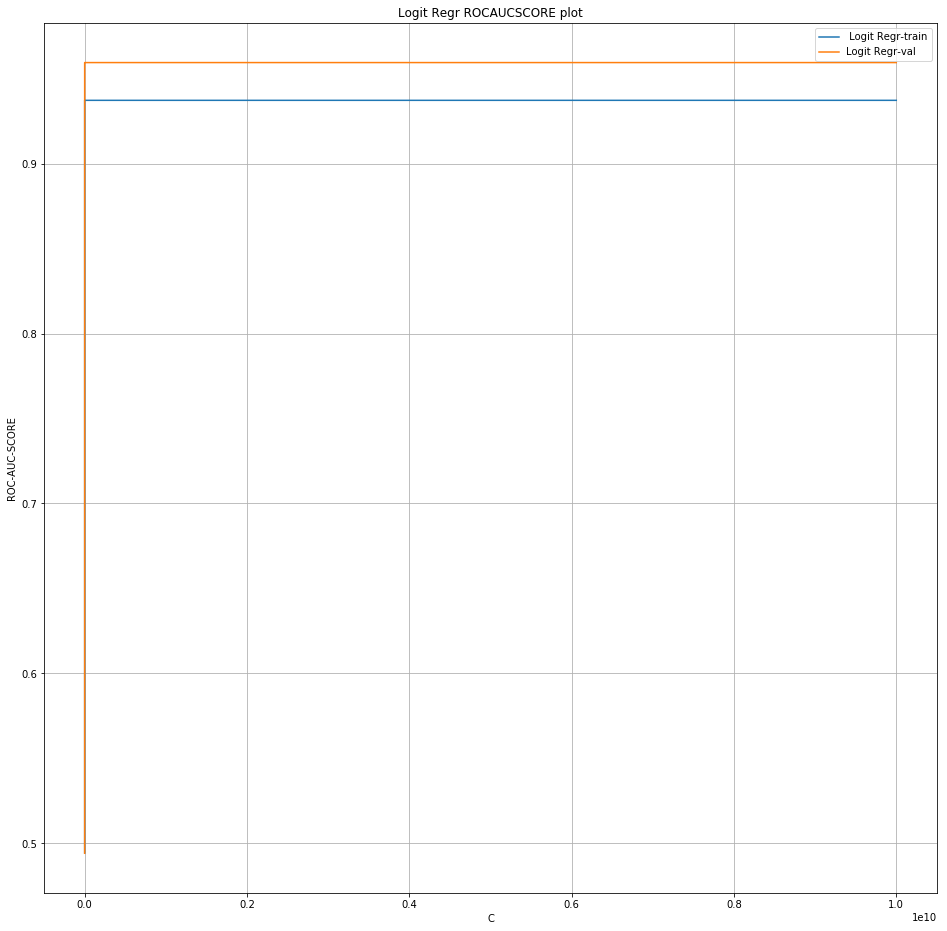

In [77]:
logregr = LogisticRegrsn()
log_regr = logregr.logRegrsn()

logregr.xtrain,logregr.xtest,logregr.xval, logregr.ytrain,logregr.ytest,logregr.yval = logregr.load_data()

# vectorise the complete corpus
logregr.BOWVectorizer()

# hyperparameter tuning for lambda
print(logregr.getlogRegresion())
return_63 = logregr.hyperparamtuning(wordvect.BOW,[0.00000000001,0.0000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],'roc_auc',5,100,1)
#output parameter 0.9211633325857863 {'C': 1}

print(return_63[0])
print(return_63[1])
print(return_63[2])

logregr.calcrocaucscore_logregrsn(10000000000)
print(logregr.rocaucscoretrn)
print(logregr.rocaucscoreval)
print( logregr.logrgr_lambda)

# testing code for displayig graphs
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr ROCAUCSCORE plot'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = logregr.logrgr_lambda
displaygraph.ydatatrn = logregr.rocaucscoretrn
displaygraph.ydataval = logregr.rocaucscoreval
displaygraph.rocacuscoregraph()

1


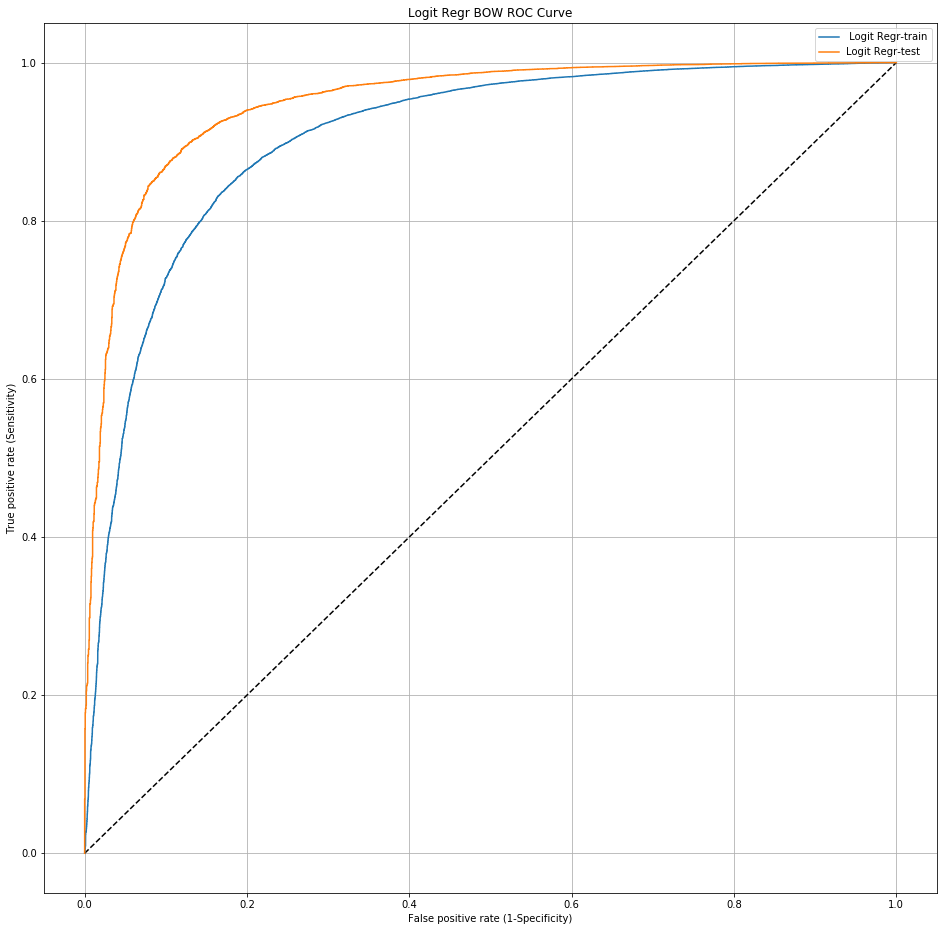

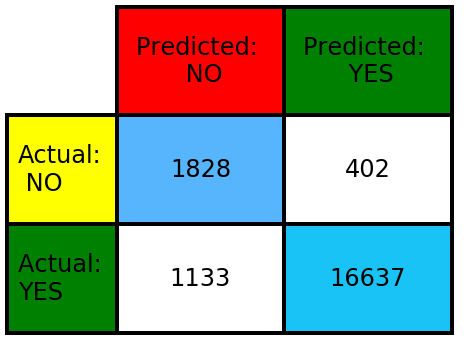

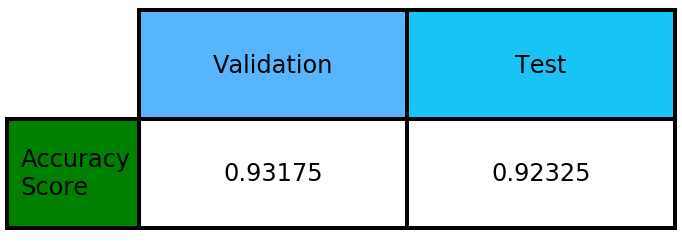

In [78]:
#process test data using logistic regression
logregr.actualClasifier_logregrsn(1)

# display ROC AUC graph for test data
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr BOW ROC Curve'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(logregr.roc_curve_test['fpr_trn'],logregr.roc_curve_test['tpr_trn'],\
                            logregr.roc_curve_test['fpr'],logregr.roc_curve_test['tpr'])
data = [[logregr.confsnmtxytstpred['tn'] ,logregr.confsnmtxytstpred['fn']],[logregr.confsnmtxytstpred['fp'],logregr.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

data1= [[logregr.accuracy_score_val,logregr.accuracy_score_test]]
displaygraph.draw_accscore(data1)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [4]:
#instantiate logistic regression object
lgrgr_l1 = LogisticRegrsn()
#instantiate logistic regression classifier
lgrgrl1_clf = lgrgr_l1.logRegrsn()

#load the data
lgrgr_l1.xtrain,lgrgr_l1.xtest,lgrgr_l1.xval, lgrgr_l1.ytrain,lgrgr_l1.ytest,lgrgr_l1.yval = lgrgr_l1.load_data()

# vectorise the training corpus
lgrgr_l1.BOWVectorizer()

# print the shapes of the data vetors
print((lgrgr_l1.xtrain).shape)
print((lgrgr_l1.xtest).shape)
print((lgrgr_l1.xval).shape)
print((lgrgr_l1.ytrain).shape)
print((lgrgr_l1.ytest).shape)
print((lgrgr_l1.yval).shape)

some feature names  ['abl', 'absolut', 'acid', 'across', 'actual', 'ad', 'add', 'addict', 'addit', 'advertis']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (64000, 1000)
the number of unique words  1000
(64000, 1000)
(20000, 1000)
(16000, 1000)
(64000,)
(20000,)
(16000,)


In [84]:
#set lambda paramater 
lgrgr_l1.set_lambdaparm(10)
#set penalty
lgrgr_l1.set_penaltyparm('l1')
print(lgrgr_l1.getlogRegresion())
#fit test data
lgrgr_l1.logRegr_fitdata(lgrgr_l1.xtest,lgrgr_l1.ytest)
lone_tst_1= lgrgr_l1.getlogRegresion()
#get coefficients
w_1 = lone_tst_1.coef_
print(np.count_nonzero(w_1))

#set lambda paramater 
lgrgr_l1.set_lambdaparm(1)
#set penalty
lgrgr_l1.set_penaltyparm('l1')
print(lgrgr_l1.getlogRegresion())
#fit test data
lgrgr_l1.logRegr_fitdata(lgrgr_l1.xtest,lgrgr_l1.ytest)
lone_tst_2 = lgrgr_l1.getlogRegresion()
#get coefficients
w_2 = lone_tst_2.coef_
print(np.count_nonzero(w_2))

#set lambda paramater 
lgrgr_l1.set_lambdaparm(0.1)
#set penalty
lgrgr_l1.set_penaltyparm('l1')
print(lgrgr_l1.getlogRegresion())
#fit test data
lgrgr_l1.logRegr_fitdata(lgrgr_l1.xtest,lgrgr_l1.ytest)
lone_tst_3 = lgrgr_l1.getlogRegresion()
#get coefficients
w_3 = lone_tst_3.coef_
print(np.count_nonzero(w_3))

#set lambda paramater 
lgrgr_l1.set_lambdaparm(0.001)
#set penalty
lgrgr_l1.set_penaltyparm('l1')
print(lgrgr_l1.getlogRegresion())
#fit test data
lgrgr_l1.logRegr_fitdata(lgrgr_l1.xtest,lgrgr_l1.ytest)
lone_tst_4 = lgrgr_l1.getlogRegresion()
#get coefficients
w_4 = lone_tst_4.coef_
print(np.count_nonzero(w_4))

10
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
987
1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
892
0.1
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
369
0.001
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_st

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

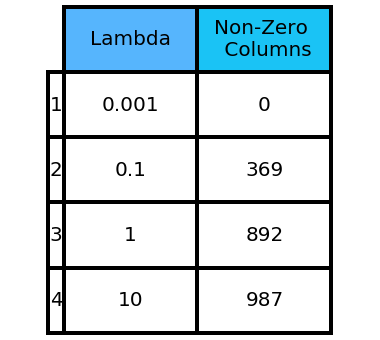

In [98]:
data2= [[0.001,0],[0.1,369],[1,892],[10,987]]
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_sparsity(data2)

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [81]:
logregr.set_lambdaparm(1)
logregr.set_penaltyparm('l2')
print(logregr.getlogRegresion())
logregr.logRegr_fitdata(logregr.xtrain,logregr.ytrain)
w = log_regr.coef_
print(np.count_nonzero(w))

1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
1000


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [5]:
# Please write all the code with proper documentation
print(type(lgrgr_l1.xtrain))
print(lgrgr_l1.xtrain.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(64000, 1000)


In [8]:
# clean data
clean_data = lgrgr_l1.xtrain
print(clean_data.shape)
# adding a small epsilon
mu,sigma = 0,0.001
epsilon = np.random.normal(mu,sigma,[64000, 1000])
# data_dash is clean data plus epsilon
data_dash=clean_data+epsilon

(64000, 1000)


In [7]:
#instantiate the logistic regression object
lgrgr_pt = LogisticRegrsn()

#instantiate the logistic regression classifier
lgrgrpt_clf = lgrgr_pt.logRegrsn()
print(lgrgrpt_clf)

# set the x_data as the clean data
lgrgr_pt.xtrain = lgrgr_l1.xtrain
lgrgr_pt.ytrain = lgrgr_l1.ytrain

# set lambda equals to 1 
lgrgr_pt.set_lambdaparm(1)

# set l2 regularization
lgrgr_pt.set_penaltyparm('l2')

#fit the clean data
lgrgr_pt.logRegr_fitdata(lgrgr_pt.xtrain,lgrgr_pt.ytrain)

# store the coefficients as weights into the weight clean vector
w_clean = lgrgrpt_clf.coef_
print(np.count_nonzero(w_clean))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
1


E:\anaconda352\envs\AmaazonFoodReview\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1000


In [10]:
#store data_dash (clean+epsilon) into training data
lgrgr_pt.xtrain = data_dash

#fit this new training data 
lgrgr_pt.logRegr_fitdata(lgrgr_pt.xtrain,lgrgr_pt.ytrain)

#store the coefficients as weights to w_dash vector
w_dash = lgrgrpt_clf.coef_
print(np.count_nonzero(w_dash))


1000


In [11]:
print(type(w_clean),w_clean.shape)
print(type(w_dash),w_dash.shape)

<class 'numpy.ndarray'> (1, 1000)
<class 'numpy.ndarray'> (1, 1000)


In [12]:
#finding the percentage change in weights
w_tmp = np.empty([1,1000])
w_tmp1 = np.empty([1,1000])
w_clean = w_clean + 10**-6
w_dash = w_dash + 10**-6
np.subtract(w_clean,w_dash,out=w_tmp)
np.divide(w_tmp,w_clean,out=w_tmp1) 
w_perchng = [wi*100 for wi in w_tmp1] 


#### In the w_perchange vector we need to find the point where the percentage drastically changes. First we plot all the data and get an initial estimate of the number of features where the data changes. This is depicted in Figure 1. Around x=200 the graph is almost near zero. In figure 2 we are plotting points till x=200 and we can see that around x=130 the change in values are constant. Finally in Figure 3. after x=76 the values almost remain constant. The conclusion is we can drop these 76 features. ####

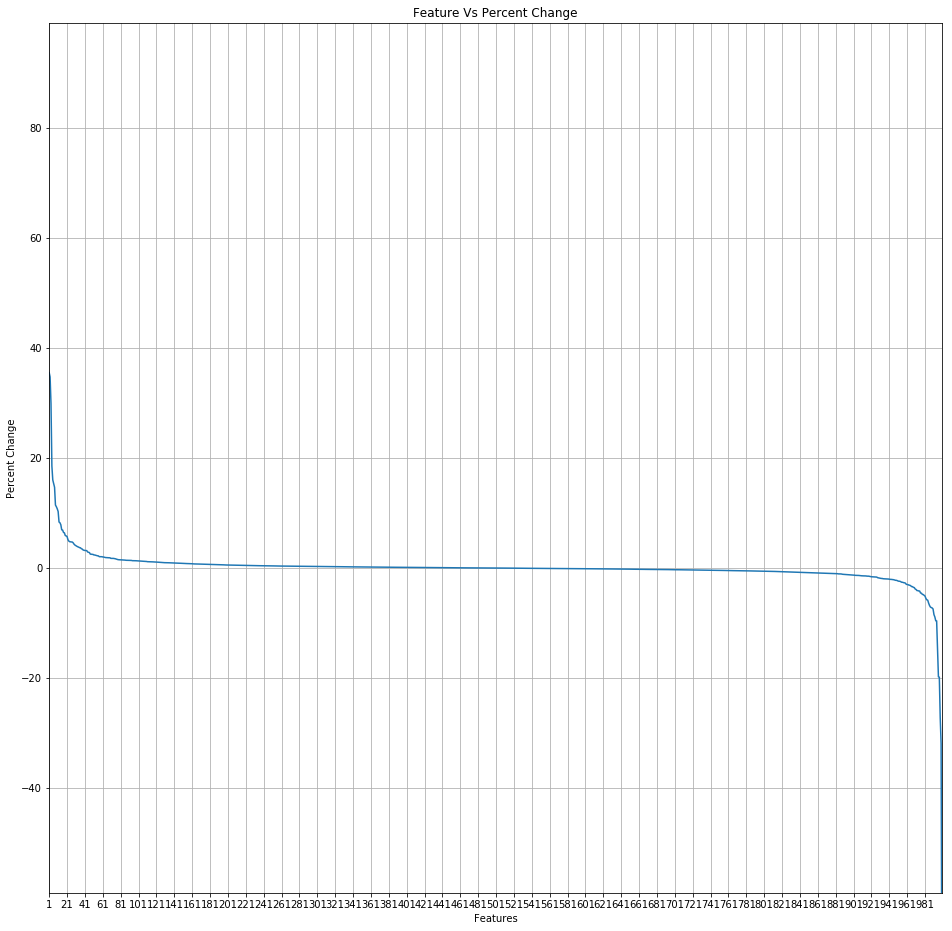

In [16]:
w_tmpsor = -np.sort(-np.asarray(w_perchng))
w_sortedperchng = w_tmpsor[::-1]
w_1 = w_sortedperchng[:,:1000]
data_x = [] 
for x in range(1,1001):    
    data_x.append(x)

x1=np.asarray(data_x)
x1 = x1.reshape(-1,1)

y1=np.asarray(w_1)
y1 = y1.reshape(-1,1)

plt.figure(figsize=(16,16))
plt.axis([1, 1000,-59,99])
plt.plot(x1,y1, label='Percent Change')

plt.xticks(np.arange(min(x1), 1000+1,20 ))
plt.xlabel('Features')
plt.ylabel('Percent Change')
plt.title('Fig: 1 Feature Vs Percent Change')
plt.grid(True)
#plt.legend()
plt.show()

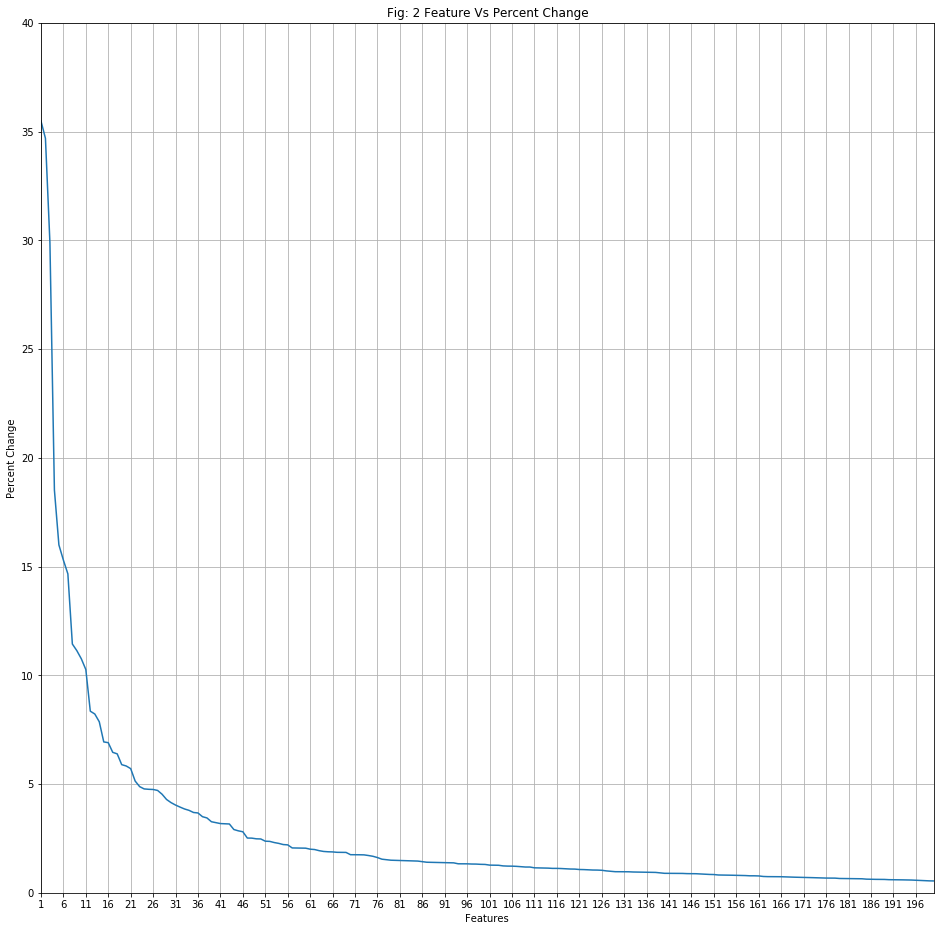

In [29]:
w_tmpsor = -np.sort(-np.asarray(w_perchng))
w_sortedperchng = w_tmpsor[::-1]
w_1 = w_sortedperchng[:,:200]
data_x = [] 
for x in range(1,201):    
    data_x.append(x)

x1=np.asarray(data_x)
x1 = x1.reshape(-1,1)

y1=np.asarray(w_1)
y1 = y1.reshape(-1,1)

plt.figure(figsize=(16,16))
plt.axis([1, 200,0,40])
plt.plot(x1,y1, label='Percent Change')

plt.xticks(np.arange(min(x1), 200+1,5.0 ))
plt.xlabel('Features')
plt.ylabel('Percent Change')
plt.title('Fig: 2 Feature Vs Percent Change')
plt.grid(True)
#plt.legend()
plt.show()

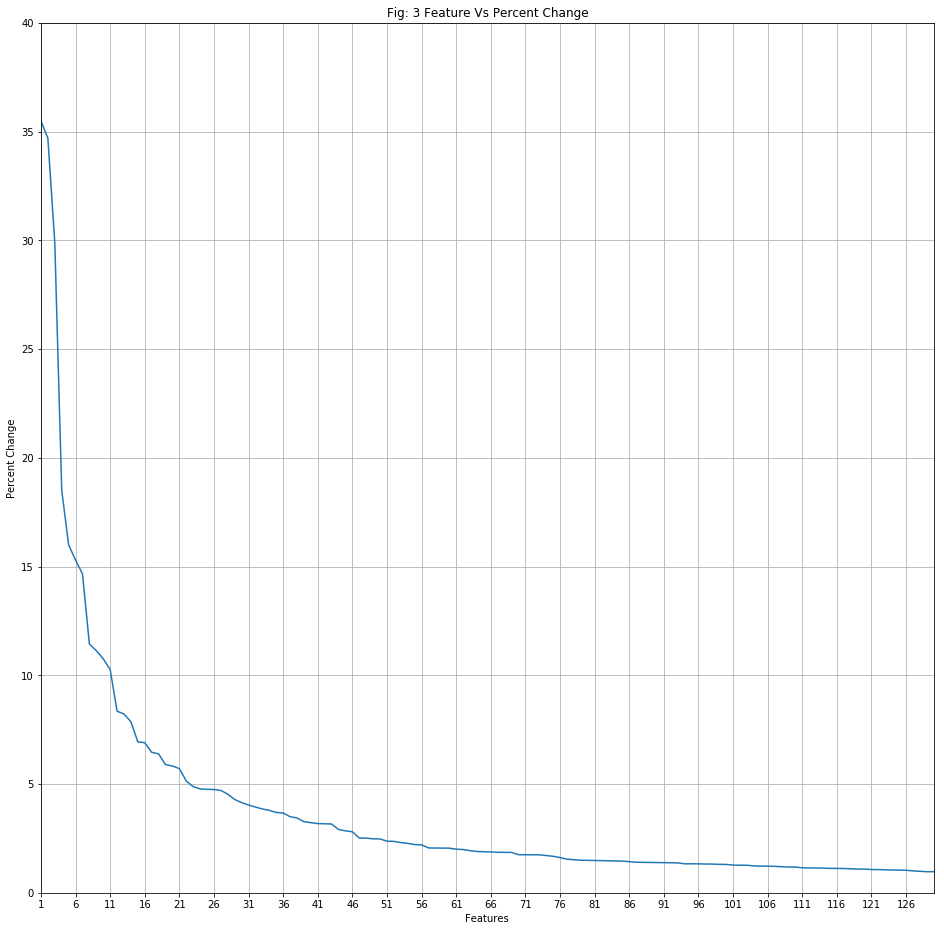

In [28]:
w_tmpsor = -np.sort(-np.asarray(w_perchng))
w_sortedperchng = w_tmpsor[::-1]
w_1 = w_sortedperchng[:,:130]
data_x = [] 
for x in range(1,131):    
    data_x.append(x)

x1=np.asarray(data_x)
x1 = x1.reshape(-1,1)

y1=np.asarray(w_1)
y1 = y1.reshape(-1,1)

plt.figure(figsize=(16,16))
plt.axis([1, 130,0,40])
plt.plot(x1,y1, label='Percent Change')

plt.xticks(np.arange(min(x1), 130+1,5.0 ))
plt.xlabel('Features')
plt.ylabel('Percent Change')
plt.title('Fig: 3 Feature Vs Percent Change')
plt.grid(True)
#plt.legend()
plt.show()

In [85]:
from scipy import stats
# pre-sort array
w_tmp_1 = np.asarray(w_perchng) 

w_tmpsor_1 = (w_tmp_1).ravel()
w_tmpsor_1 = sorted(np.asarray(w_tmpsor_1),key=float)
print(type(w_tmpsor_1))
#print(w_tmpsor_1)

# calculate percentiles using scipy func percentileofscore on each array element
df_perchng = pd.Series(w_tmpsor_1)
prcntls = df_perchng.apply(lambda x: stats.percentileofscore(w_tmpsor_1, x))

#checking that the results are correct:
df = pd.DataFrame({'data': df_perchng, 'percentiles': prcntls, 'featurenames': lgrgr_l1.count_vect.get_feature_names()})    
print(df)
#df_sorted = df.sort_values(by='data')
#print(df_sorted)


<class 'list'>
          data  percentiles featurenames
0   -83.690190          0.1          abl
1   -31.915668          0.2      absolut
2   -27.138467          0.3         acid
3   -19.825809          0.4       across
4   -19.774519          0.5       actual
5   -14.920021          0.6           ad
6    -9.606266          0.7          add
7    -9.573110          0.8       addict
8    -8.890652          0.9        addit
9    -8.458384          1.0     advertis
10   -7.447325          1.1    aftertast
11   -7.258504          1.2        again
12   -7.186293          1.3          age
13   -7.083141          1.4          ago
14   -6.791987          1.5         agre
15   -6.366837          1.6          air
16   -5.832302          1.7          all
17   -5.779219          1.8       allerg
18   -5.533660          1.9      allergi
19   -5.099714          2.0        allow
20   -4.964140          2.1       almond
21   -4.824241          2.2       almost
22   -4.794247          2.3         alon
2

In [63]:
uselesfeat = df.where(df['data']>29.895689).dropna()
#uselesfeat.dropna()
print(uselesfeat)
lgrgr_l1.count_vect.get_feature_names()[0:15]

          data  percentiles featurenames
15   34.698758         99.9          air
558  35.499030        100.0        night


['abl',
 'absolut',
 'acid',
 'across',
 'actual',
 'ad',
 'add',
 'addict',
 'addit',
 'advertis',
 'aftertast',
 'again',
 'age',
 'ago',
 'agre']

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [196]:
# Please write all the code with proper documentation

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

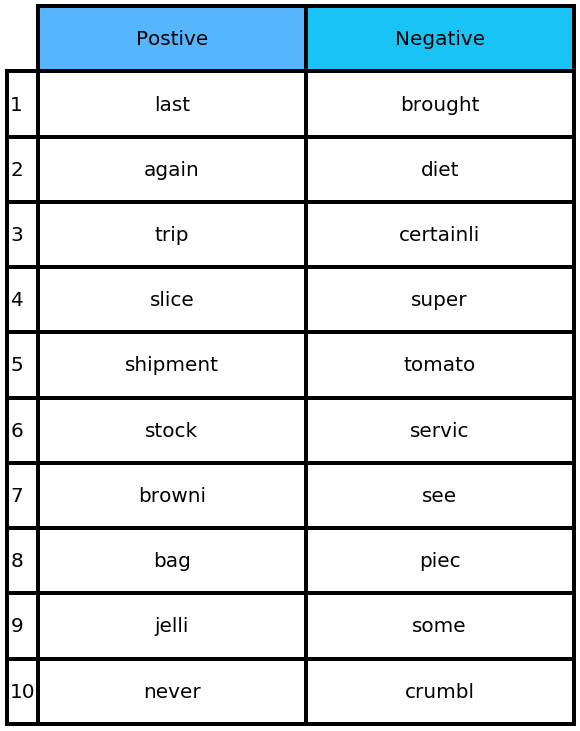

In [61]:
feat1_pos=[]
feat0_neg=[]
features1=[]

class_labels = log_regr.classes_
feature_names = logregr.count_vect.get_feature_names()
top10n_neg = sorted(zip((log_regr.predict_proba(logregr.xtest))[:,0], feature_names),reverse=True)[:10]
top10n_pos = sorted(zip((log_regr.predict_proba(logregr.xtest))[:,1], feature_names),reverse=True)[:10]

for coef, feat in top10n_neg:
    feat0_neg.append(feat)


for coef, feat in top10n_pos:
    feat1_pos.append(feat)
    
i=0
while i< int(len(feat1_pos)):
    feat_item=[]
    feat_item.append(feat1_pos[i])
    feat_item.append(feat0_neg[i])
    features1.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features1)

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [62]:
#instantiate logistic regression object and classifier
lgrgr_tfidf = LogisticRegrsn()
lgrgrtfidf_clf = lgrgr_tfidf.logRegrsn()

# load the data
lgrgr_tfidf.xtrain,lgrgr_tfidf.xtest,lgrgr_tfidf.xval, lgrgr_tfidf.ytrain,lgrgr_tfidf.ytest,lgrgr_tfidf.yval = lgrgr_tfidf.load_data()

# vectorise the complete corpus
lgrgr_tfidf.tfIdfVectorizer()

# print the shapes of the data vetors
print((lgrgr_tfidf.xtrain).shape)
print((lgrgr_tfidf.xtest).shape)
print((lgrgr_tfidf.xval).shape)
print((lgrgr_tfidf.ytrain).shape)
print((lgrgr_tfidf.ytest).shape)
print((lgrgr_tfidf.yval).shape)

some sample features(unique words in the corpus) ['ab', 'abandon', 'abc', 'abdomin', 'abil', 'abl', 'abl buy', 'abl chew', 'abl drink', 'abl eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (64000, 40359)
the number of unique words including both unigrams and bigrams  40359
(64000, 40359)
(20000, 40359)
(16000, 40359)
(64000,)
(20000,)
(16000,)


In [63]:
print(lgrgrtfidf_clf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [64]:
# hyperparameter tuning for lambda
print(lgrgr_tfidf.getlogRegresion())
return_63 = lgrgr_tfidf.hyperparamtuning(wordvect.TFIDF,[0.00000000001,0.0000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],'roc_auc',5,100,1)

print(return_63[0])
print(return_63[1])
print(return_63[2])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Fitting 5 folds for each of 22 candidates, totalling 110 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.6146325444184904, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.6287481174746223, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.6303265016424122, total=   0.1s
[Parallel

[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.9557334124885358, total=   3.3s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   58.1s remaining:    0.0s
[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.9481904518673268, total=   3.6s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  1.0min remaining:    0.0s
[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.9470360441649665, total=   3.3s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  1.1min remaining:    0.0s
[CV] C=10000 .........................................................
[CV] ................ C=10000, score=0.9452990596627067, total=   3.4s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:  1.1min remaining:    0.0s
[CV] C=10000 .........................................................
[CV] ................ C=10000, score=0.94

       scoring='roc_auc', verbose=100)


In [65]:
#run with different lambdas to get multiple rocauc scores
lgrgr_tfidf.calcrocaucscore_logregrsn(10000000000)
print(lgrgr_tfidf.rocaucscoretrn)
print(lgrgr_tfidf.rocaucscoreval)
print( lgrgr_tfidf.logrgr_lambda)

1e-11
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-11
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-10
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-09
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999

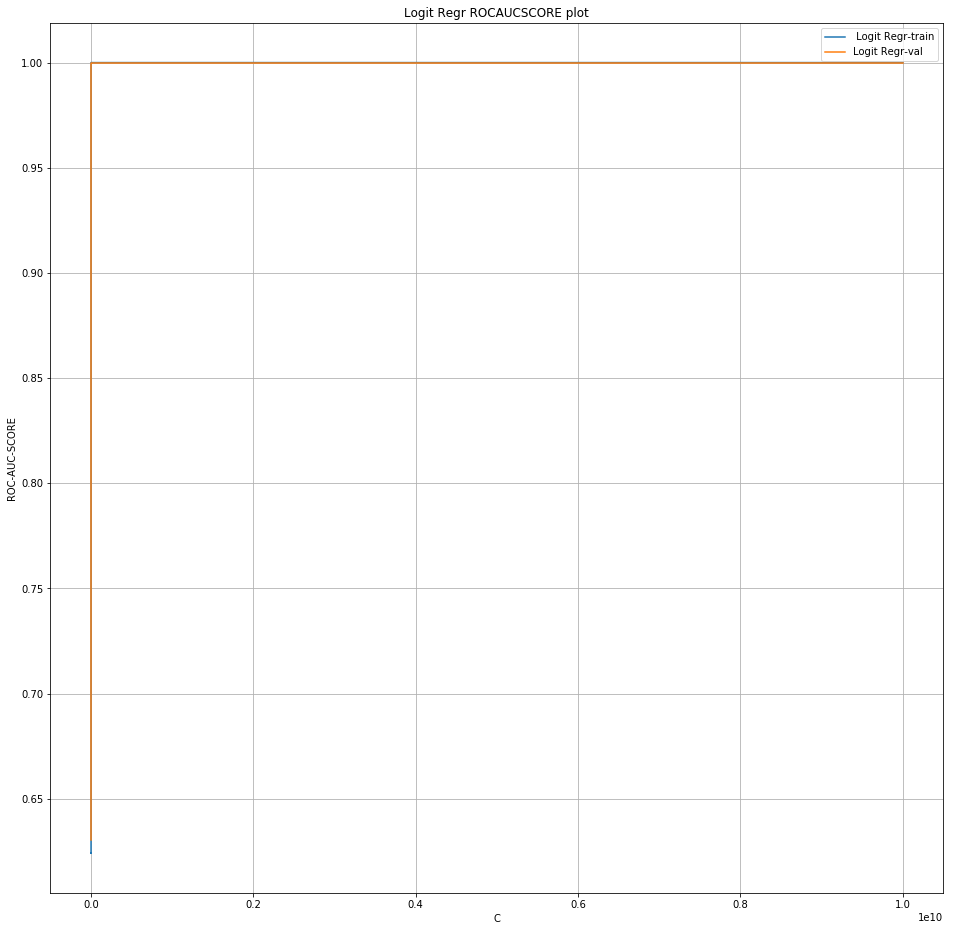

In [66]:
#display rocauc scores
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr ROCAUCSCORE plot'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = lgrgr_tfidf.logrgr_lambda
displaygraph.ydatatrn = lgrgr_tfidf.rocaucscoretrn
displaygraph.ydataval = lgrgr_tfidf.rocaucscoreval
displaygraph.rocacuscoregraph()

In [67]:
#output of gridsearchcv lambda equals 10 use that with the teest data
#process logistic regression
lgrgr_tfidf.actualClasifier_logregrsn(10)

10


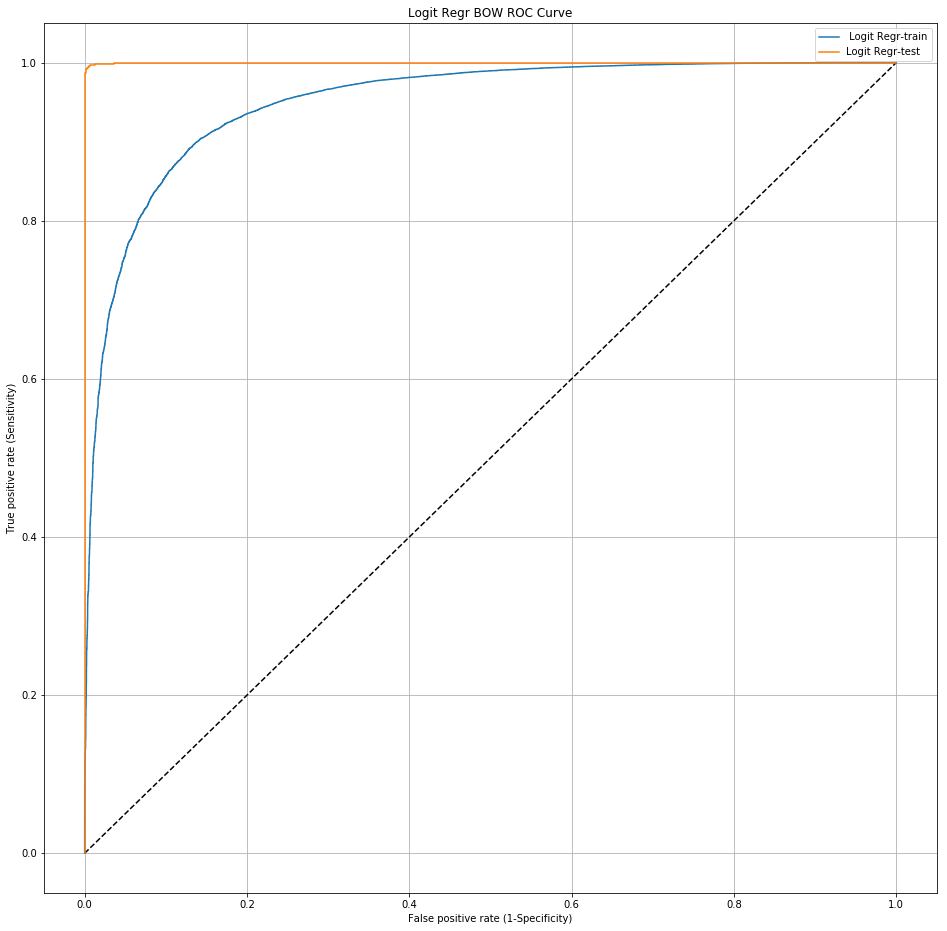

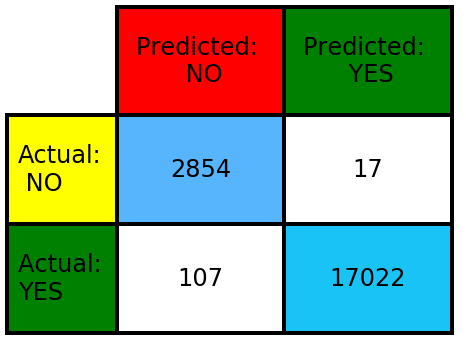

In [68]:
#display the output of logistic regression of test data
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr BOW ROC Curve'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(lgrgr_tfidf.roc_curve_test['fpr_trn'],lgrgr_tfidf.roc_curve_test['tpr_trn'],\
                            lgrgr_tfidf.roc_curve_test['fpr'],lgrgr_tfidf.roc_curve_test['tpr'])
data = [[lgrgr_tfidf.confsnmtxytstpred['tn'] ,lgrgr_tfidf.confsnmtxytstpred['fn']],[lgrgr_tfidf.confsnmtxytstpred['fp'],lgrgr_tfidf.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

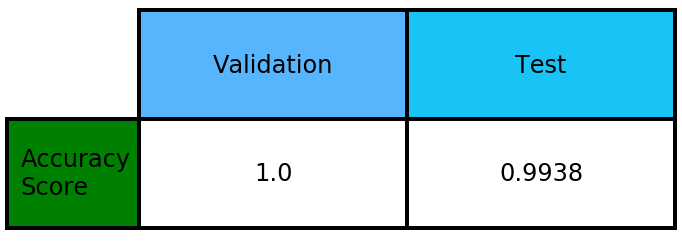

In [69]:
data1= [[lgrgr_tfidf.accuracy_score_val,lgrgr_tfidf.accuracy_score_test]]
#data1=[[0,1]]
displaygraph.draw_accscore(data1)

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [60]:
# instantiate logistic regression object
lgrgr_tfidf_l1 = LogisticRegrsn()
#instantiate logistic regression clasifier
lgrgrtfidf_clf = lgrgr_tfidf_l1.logRegrsn()

#load the data into the logistic regression object
lgrgr_tfidf_l1.xtrain,lgrgr_tfidf_l1.xtest,lgrgr_tfidf_l1.xval, lgrgr_tfidf_l1.ytrain,lgrgr_tfidf_l1.ytest,lgrgr_tfidf_l1.yval = lgrgr_tfidf_l1.load_data()

# vectorise the training corpus
lgrgr_tfidf_l1.tfIdfVectorizer()

# print the shapes of the data vetors
print((lgrgr_tfidf_l1.xtrain).shape)
print((lgrgr_tfidf_l1.xtest).shape)
print((lgrgr_tfidf_l1.xval).shape)
print((lgrgr_tfidf_l1.ytrain).shape)
print((lgrgr_tfidf_l1.ytest).shape)
print((lgrgr_tfidf_l1.yval).shape)

some sample features(unique words in the corpus) ['ab', 'abandon', 'abc', 'abdomin', 'abil', 'abl', 'abl buy', 'abl chew', 'abl drink', 'abl eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (64000, 40359)
the number of unique words including both unigrams and bigrams  40359
(64000, 40359)
(20000, 40359)
(16000, 40359)
(64000,)
(20000,)
(16000,)


In [61]:
# set arbitary values of lambda
lgrgr_tfidf_l1.set_lambdaparm(10)

# set penalty equals l1
lgrgr_tfidf_l1.set_penaltyparm('l1')

#print the logistic regression classifier to check the parameters
print(lgrgr_tfidf_l1.getlogRegresion())

# fir the test data
lgrgr_tfidf_l1.logRegr_fitdata(lgrgr_tfidf_l1.xtest,lgrgr_tfidf_l1.ytest)

#get the handle to the logistic regression classifier
lone_tst_1= lgrgr_tfidf_l1.getlogRegresion()

#get the coefficients
w_1 = lone_tst_1.coef_
print(np.count_nonzero(w_1))

# set arbitary values of lambda
lgrgr_tfidf_l1.set_lambdaparm(1)

# set penalty equals l1
lgrgr_tfidf_l1.set_penaltyparm('l1')

#print the logistic regression classifier to check the parameters
print(lgrgr_tfidf_l1.getlogRegresion())

# fir the test data
lgrgr_tfidf_l1.logRegr_fitdata(lgrgr_tfidf_l1.xtest,lgrgr_tfidf_l1.ytest)

#get the coefficients
lone_tst_2 = lgrgr_tfidf_l1.getlogRegresion()
w_2 = lone_tst_2.coef_
print(np.count_nonzero(w_2))

# set arbitary values of lambda
lgrgr_tfidf_l1.set_lambdaparm(0.1)

# set penalty equals l1
lgrgr_tfidf_l1.set_penaltyparm('l1')

#print the logistic regression classifier to check the parameters
print(lgrgr_tfidf_l1.getlogRegresion())

# fir the test data
lgrgr_tfidf_l1.logRegr_fitdata(lgrgr_tfidf_l1.xtest,lgrgr_tfidf_l1.ytest)

#get the coefficients
lone_tst_3 = lgrgr_tfidf_l1.getlogRegresion()
w_3 = lone_tst_3.coef_
print(np.count_nonzero(w_3))

# set arbitary values of lambda
lgrgr_tfidf_l1.set_lambdaparm(0.001)

# set penalty equals l1
lgrgr_tfidf_l1.set_penaltyparm('l1')

#print the logistic regression classifier to check the parameters
print(lgrgr_tfidf_l1.getlogRegresion())

# fir the test data
lgrgr_tfidf_l1.logRegr_fitdata(lgrgr_tfidf_l1.xtest,lgrgr_tfidf_l1.ytest)

#get the coefficients
lone_tst_4 = lgrgr_tfidf_l1.getlogRegresion()
w_4 = lone_tst_4.coef_
print(np.count_nonzero(w_4))

10
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
3182
1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
474
0.1
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
28
0.001
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_st

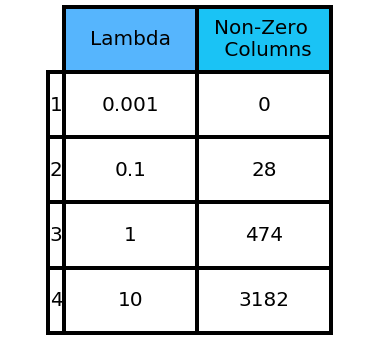

In [4]:
data2= [[0.001,0],[0.1,28],[1,474],[10,3182]]
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_sparsity(data2)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [71]:
#l2 regulariation happends by default use  the previously used logisitc regression classifier
print(lgrgrtfidf_clf)
w = lgrgrtfidf_clf.coef_
print(np.count_nonzero(w))

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
39209


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [74]:
# Please write all the code with proper documentation

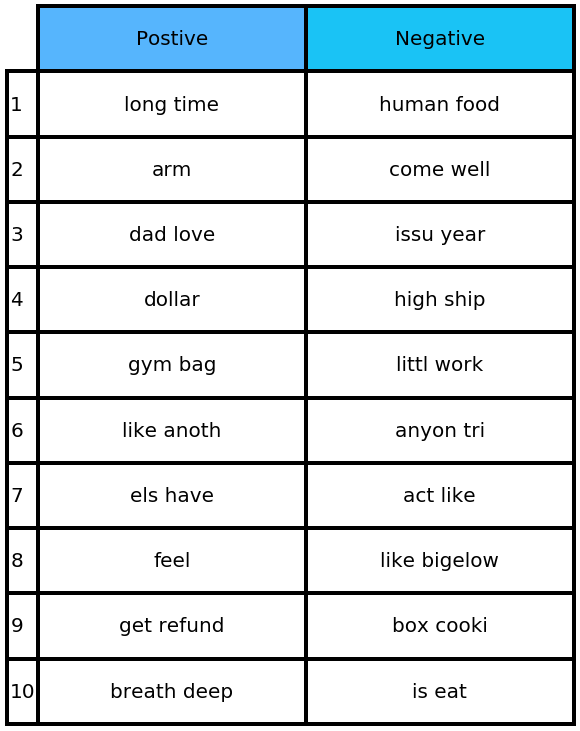

In [73]:
feat1_pos=[]
feat0_neg=[]
features1=[]

class_labels = lgrgrtfidf_clf.classes_
feature_names = lgrgr_tfidf.tf_idf_vect.get_feature_names()
top10n_neg = sorted(zip((lgrgrtfidf_clf.predict_proba(lgrgr_tfidf.xtest))[:,0], feature_names),reverse=True)[:10]
top10n_pos = sorted(zip((lgrgrtfidf_clf.predict_proba(lgrgr_tfidf.xtest))[:,1], feature_names),reverse=True)[:10]

for coef, feat in top10n_neg:
    feat0_neg.append(feat)


for coef, feat in top10n_pos:
    feat1_pos.append(feat)
    
i=0
while i< int(len(feat1_pos)):
    feat_item=[]
    feat_item.append(feat1_pos[i])
    feat_item.append(feat0_neg[i])
    features1.append(feat_item)
    i +=1
    
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_posnegwords(features1)

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.8460018878132247, 0.9052360918397744, 0.9083179365968288, 0.9083325549541096, 0.9083273190194835, 0.9083264757645549, 0.9083263633305643, 0.9083263885312863, 0.9083263788387008, 0.908326378838701, 0.908326378838701]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.8244052533438749, 0.8683950891272803, 0.8748570264256816, 0.8754673982050332, 0.8754626539838641, 0.8754612060722087, 0.8754616373650421, 0.8754616373650423, 0.8754616065584113, 0.8754616065584113]
[1e-11, 9.999999999999999e-11, 9.999999999999999e-10, 9.999999999999999e-09, 9.999999999999998e-08, 9.999999999999997e-07, 9.999999999999997e-06, 9.999999999999998e-05, 0.0009999999999999998, 0.009999999999999998, 0.09999999999999998, 0.9999999999999998, 9.999999999999998, 99.99999999999999, 999.9999999999999, 9999.999999999998, 99999.99999999999, 999999.9999999999, 9999999.999999998]


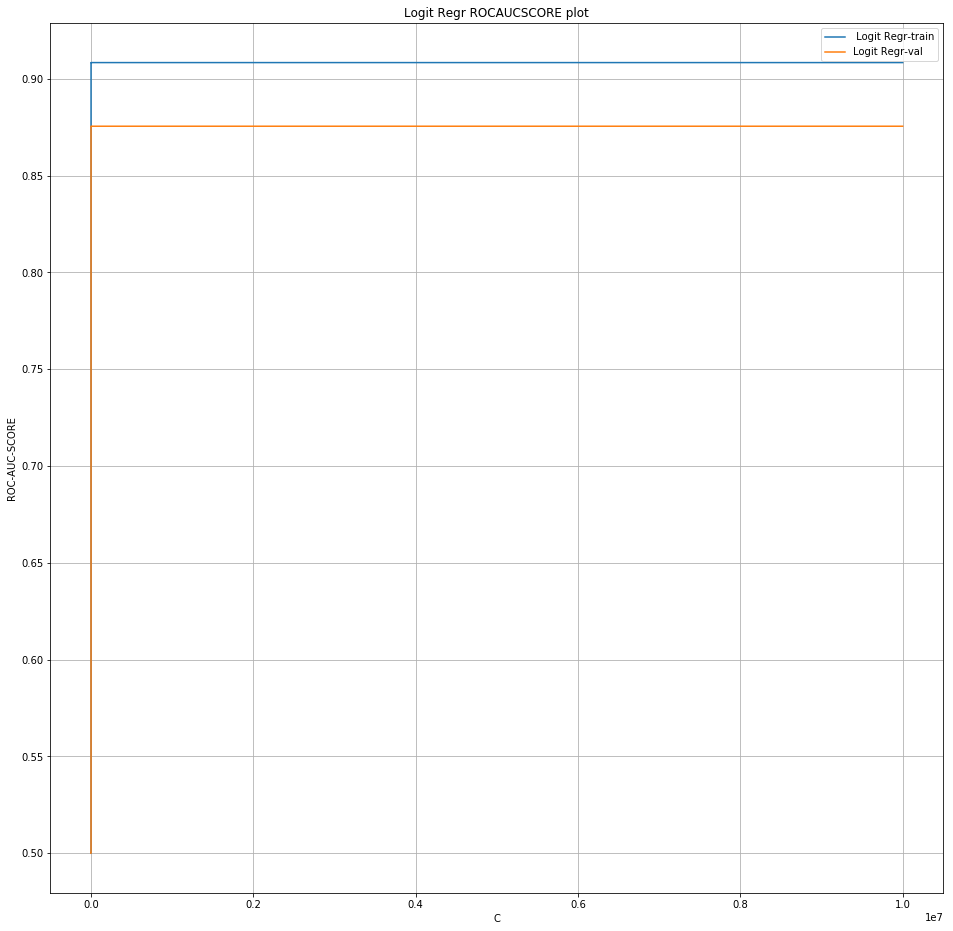

1


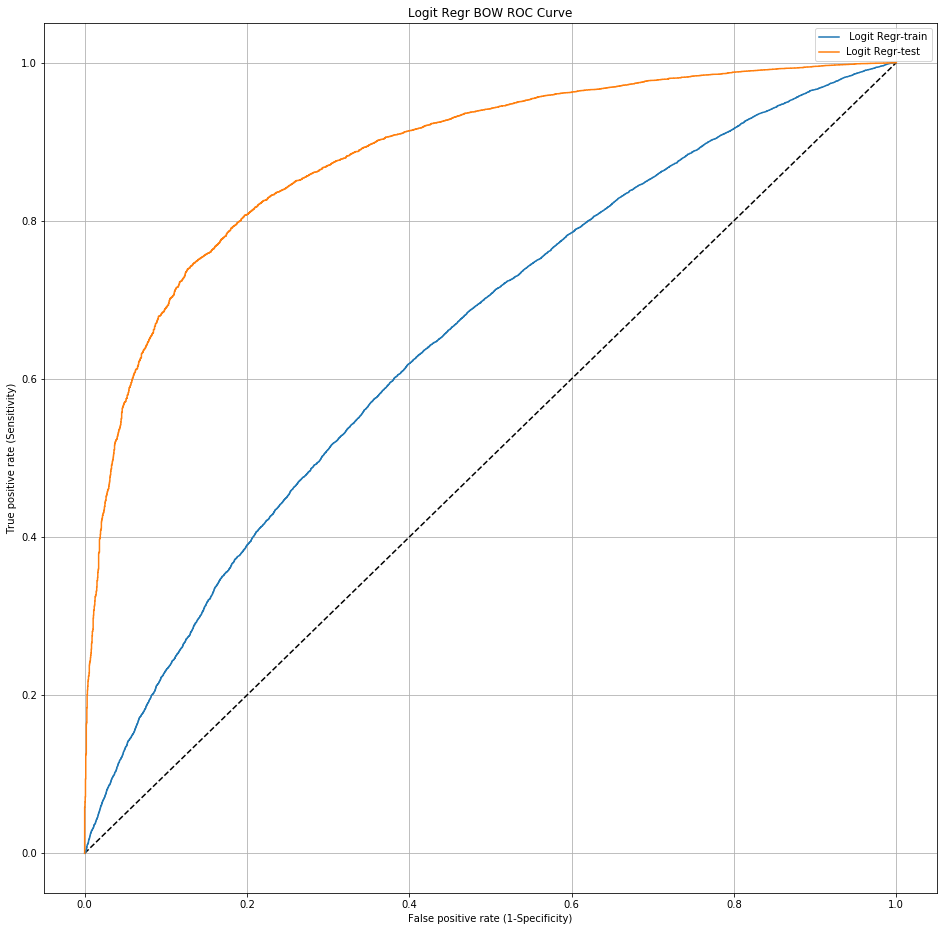

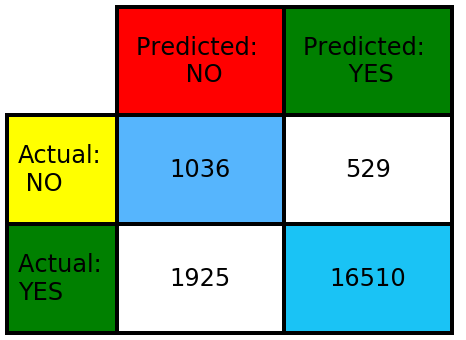

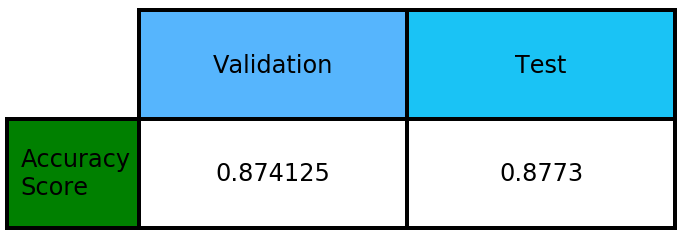

In [12]:
# Train your own Word2Vec model using your own text corpus

# initialize the logistic regression object
logregr_avgw2v = LogisticRegrsn()

#initialize logistic regression classifier
log_regr_avgw2v = logregr_avgw2v.logRegrsn()

#load the data
x_train,x_test,x_val, y_trn,y_tst,y_val = logregr_avgw2v.load_data()

# split the data into sentences
listsent_xtrain=[]
listsent_xtest=[]
listsent_xval=[]

listsent_xtrain = logregr_avgw2v.listsent(x_train)
listsent_xtest = logregr_avgw2v.listsent(x_test)
listsent_xval = logregr_avgw2v.listsent(x_val)

#create wordtovec model
w2v_mdl_xtrain=Word2Vec(listsent_xtrain,min_count=5,size=50, workers=4)
w2v_mdl_xtest=Word2Vec(listsent_xtest,min_count=5,size=50, workers=4)
w2v_mdl_xval=Word2Vec(listsent_xval,min_count=5,size=50, workers=4)

#get the vocabulary from the model
w2v_words_trn = list(w2v_mdl_xtrain.wv.vocab)
w2v_words_tst = list(w2v_mdl_xtest.wv.vocab)
w2v_words_val = list(w2v_mdl_xval.wv.vocab)

#create sent vectors for training data
w2v_xtrain = logregr_avgw2v.w2vec_crea(listsent_xtrain,w2v_mdl_xtrain,w2v_words_trn)

#create sent vectors for test data
w2v_xtest = logregr_avgw2v.w2vec_crea(listsent_xtest,w2v_mdl_xtest,w2v_words_tst)

#create sent vectors for validation data
w2v_xval = logregr_avgw2v.w2vec_crea(listsent_xval,w2v_mdl_xval,w2v_words_val)

logregr_avgw2v.xtrain = w2v_xtrain
logregr_avgw2v.xtest = w2v_xtest
logregr_avgw2v.xval = w2v_xval
logregr_avgw2v.ytrain = y_trn
logregr_avgw2v.ytest = y_tst
logregr_avgw2v.yval = y_val

print(len(logregr_avgw2v.xtrain)
print(len(logregr_avgw2v.xtest)
print(len(logregr_avgw2v.xval)

#parameter tuning lambda
return_hyparmtune = logregr_avgw2v.hyperparamtuning(wordvect.W2VAVG,[0.00000000001,0.0000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],'roc_auc',5,100,1)

print(return_hyparmtune[0],return_hyparmtune[1],return_hyparmtune[2])
#output hyperparmtuning 0.9053700080793041 {'C': 1}

#Process the training and validation data sets using logistic regression 
#calculate roc_auc_score
logregr_avgw2v.calcrocaucscore_logregrsn(10000000)

print(logregr_avgw2v.rocaucscoretrn)
print(logregr_avgw2v.rocaucscoreval)
print( logregr_avgw2v.logrgr_lambda)


# plot training and validation datasets roc_auc score
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr ROCAUCSCORE plot'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = logregr_avgw2v.logrgr_lambda
displaygraph.ydatatrn = logregr_avgw2v.rocaucscoretrn
displaygraph.ydataval = logregr_avgw2v.rocaucscoreval
displaygraph.rocacuscoregraph()

#using the hyper parameter tuned value of lambda equal to 1
#perform logistic regression using test data
logregr_avgw2v.actualClasifier_logregrsn(1)


#displayig graphs for row-auc score for test data
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr BOW ROC Curve'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(logregr_avgw2v.roc_curve_test['fpr_trn'],logregr_avgw2v.roc_curve_test['tpr_trn'],\
                            logregr_avgw2v.roc_curve_test['fpr'],logregr_avgw2v.roc_curve_test['tpr'])
# display the confusion matrix
data = [[logregr_avgw2v.confsnmtxytstpred['tn'] ,logregr_avgw2v.confsnmtxytstpred['fn']],[logregr_avgw2v.confsnmtxytstpred['fp'],logregr_avgw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

#display the accuracy score
data1= [[logregr_avgw2v.accuracy_score_val,logregr_avgw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [8]:
#set lambda and penalty
logregr_avgw2v.set_penaltyparm('l1')
logregr_avgw2v.set_lambdaparm(0.001)
#fit test data
logregr_avgw2v.logRegr_fitdata(logregr_avgw2v.xtest,logregr_avgw2v.ytest)
print(log_regr_avgw2v)
#get coefficients
w = log_regr_avgw2v.coef_
print(np.count_nonzero(w))

#set lambda and penalty
logregr_avgw2v.set_penaltyparm('l1')
logregr_avgw2v.set_lambdaparm(0.1)
#fit test data
logregr_avgw2v.logRegr_fitdata(logregr_avgw2v.xtest,logregr_avgw2v.ytest)
print(log_regr_avgw2v)
#get coefficients
w = log_regr_avgw2v.coef_
print(np.count_nonzero(w))

#set lambda and penalty
logregr_avgw2v.set_penaltyparm('l1')
logregr_avgw2v.set_lambdaparm(1)
#fit test data
logregr_avgw2v.logRegr_fitdata(logregr_avgw2v.xtest,logregr_avgw2v.ytest)
print(log_regr_avgw2v)
#get coefficients
w = log_regr_avgw2v.coef_
print(np.count_nonzero(w))

#set lambda and penalty
logregr_avgw2v.set_penaltyparm('l1')
logregr_avgw2v.set_lambdaparm(10)
#fit test data
logregr_avgw2v.logRegr_fitdata(logregr_avgw2v.xtest,logregr_avgw2v.ytest)
print(log_regr_avgw2v)
#get coefficients
w = log_regr_avgw2v.coef_
print(np.count_nonzero(w))

0.001
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
2
0.1
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
33
1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
50
10
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=

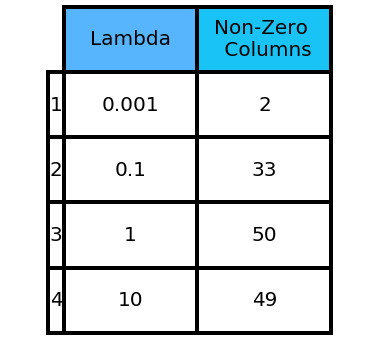

In [10]:
data2= [[0.001,2],[0.1,33],[1,50],[10,49]]
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_sparsity(data2)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [76]:
logregr_avgw2v.set_penaltyparm('l2')
logregr_avgw2v.set_lambdaparm(1)
logregr_avgw2v.logRegr_fitdata(logregr_avgw2v.xtest,logregr_avgw2v.ytest)
print(log_regr_avgw2v)
#print(log_regr_tfidfwtw2v.coef_)
w = log_regr_avgw2v.coef_
print(np.count_nonzero(w))

1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
50


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [13]:
#instantiate logistic regression object and classifier
logregr_tfidfwtw2v = LogisticRegrsn()
log_regr_tfidfwtw2v = logregr_tfidfwtw2v.logRegrsn()

#load the data
logregr_tfidfwtw2v.xtrain,logregr_tfidfwtw2v.xtest,logregr_tfidfwtw2v.xval, logregr_tfidfwtw2v.ytrain,logregr_tfidfwtw2v.ytest,logregr_tfidfwtw2v.yval = logregr_tfidfwtw2v.load_data()

#instantiate the vectorizer
tfidf_model = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_mtx_train = tfidf_model.fit_transform(logregr_tfidfwtw2v.xtrain)
tfidf_mtx_test = tfidf_model.fit_transform(logregr_tfidfwtw2v.xtest)
tfidf_mtx_val = tfidf_model.fit_transform(logregr_tfidfwtw2v.xval)

#print(list(tfidf_model.idf_))
print(type(tfidf_mtx_train))
print(tfidf_mtx_train.shape)
print(tfidf_mtx_test.shape)
print(tfidf_mtx_val.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(64000, 500)
(20000, 500)
(16000, 500)


In [14]:
#create dictionary for the training/ test and validation set
dict_train = dict(zip(tfidf_model.get_feature_names(), list(tfidf_mtx_train[0,:].nonzero()[1])))

dict_test = dict(zip(tfidf_model.get_feature_names(), list(tfidf_mtx_test[0,:].nonzero()[1])))


dict_val = dict(zip(tfidf_model.get_feature_names(), list(tfidf_mtx_val[0,:].nonzero()[1])))

#get feature names from the model
tfidf_feat = tfidf_model.get_feature_names()

#convert training data to list of sentences
lstsnt_xtrain=[]
lstsnt_xtest=[]
lstsnt_xval=[]

lstsnt_xtrain = logregr_tfidfwtw2v.listsent(logregr_tfidfwtw2v.xtrain)
lstsnt_xtest = logregr_tfidfwtw2v.listsent(logregr_tfidfwtw2v.xtest)
lstsnt_xval = logregr_tfidfwtw2v.listsent(logregr_tfidfwtw2v.xval)

#create the word to vec model
# min_count = 5 considers only words that occured atleast 5 times
w2v_mdl_xtrain=Word2Vec(lstsnt_xtrain,min_count=5,size=50, workers=4)
w2v_mdl_xtest=Word2Vec(lstsnt_xtest,min_count=5,size=50, workers=4)
w2v_mdl_xval=Word2Vec(lstsnt_xval,min_count=5,size=50, workers=4)

#get the vocabulary for the word to vec model
w2v_words_trn = list(w2v_mdl_xtrain.wv.vocab)
w2v_words_tst = list(w2v_mdl_xtest.wv.vocab)
w2v_words_val = list(w2v_mdl_xval.wv.vocab)


In [15]:
print(type(tfidf_feat),len(tfidf_feat))
print(type(lstsnt_xtrain),len(lstsnt_xtrain))
print(type(w2v_mdl_xtrain))
print(type(w2v_words_trn),len(w2v_words_trn))
print(type(dict_train))

<class 'list'> 500
<class 'list'> 64000
<class 'gensim.models.word2vec.Word2Vec'>
<class 'list'> 10881
<class 'dict'>


In [16]:
#function to create the tfidf weighted word to vec models
def tfidfwtw2v_crea(tfidf_feat, list_of_sentance, w2v_model,w2v_words,diction):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat and  word in diction:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                denom = sent.count(word)/len(sent)
                tf_idf = diction[word]*(denom)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors    

In [17]:
#creating the tfidf weighted word to vec models for training data
tfidfwtw2v_xtrain = tfidfwtw2v_crea(tfidf_feat,lstsnt_xtrain,w2v_mdl_xtrain,w2v_words_trn,dict_train)
logregr_tfidfwtw2v.xtrain = tfidfwtw2v_xtrain

100%|██████████| 64000/64000 [01:15<00:00, 845.66it/s]


In [18]:
#creating the tfidf weighted word to vec models for test data
tfidfwtw2v_xtest = tfidfwtw2v_crea(tfidf_feat,lstsnt_xtest,w2v_mdl_xtest,w2v_words_tst,dict_test)
logregr_tfidfwtw2v.xtest = tfidfwtw2v_xtest

100%|██████████| 20000/20000 [00:24<00:00, 816.55it/s]


In [19]:
#creating the tfidf weighted word to vec models for validation data
tfidfwtw2v_xval = tfidfwtw2v_crea(tfidf_feat,lstsnt_xval,w2v_mdl_xval,w2v_words_val,dict_val)
logregr_tfidfwtw2v.xval = tfidfwtw2v_xval

100%|██████████| 16000/16000 [00:19<00:00, 818.41it/s]


In [36]:
return_hyparmtune = logregr_tfidfwtw2v.hyperparamtuning(wordvect.TFIDFAVG,[0.00000000001,0.0000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000],'roc_auc',5,100,1)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.5698494192877963, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.5634991483456161, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] C=1e-11 .........................................................
[CV] ................. C=1e-11, score=0.572171073696517, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[CV] C=1e-11 .........................................................
[CV] ................ C=1e-11, score=0.5617090595891954, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elaps

[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.5693588043803499, total=   0.7s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   42.1s remaining:    0.0s
[CV] C=1000 ..........................................................
[CV] ................. C=1000, score=0.5663520939613793, total=   0.8s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   43.0s remaining:    0.0s
[CV] C=10000 .........................................................
[CV] ................ C=10000, score=0.5648212523864056, total=   0.8s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   43.9s remaining:    0.0s
[CV] C=10000 .........................................................
[CV] ................. C=10000, score=0.577816757969107, total=   0.7s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   44.8s remaining:    0.0s
[CV] C=10000 .........................................................
[CV] ................ C=10000, score=0.58

1e-11
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-11
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-10
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999999999999e-09
Fitting probability generation and roc auc score generation for training data complete...
Fitting probability generation and roc auc score generation for validation data complete...
Predicting labels for training data complete...
9.999999

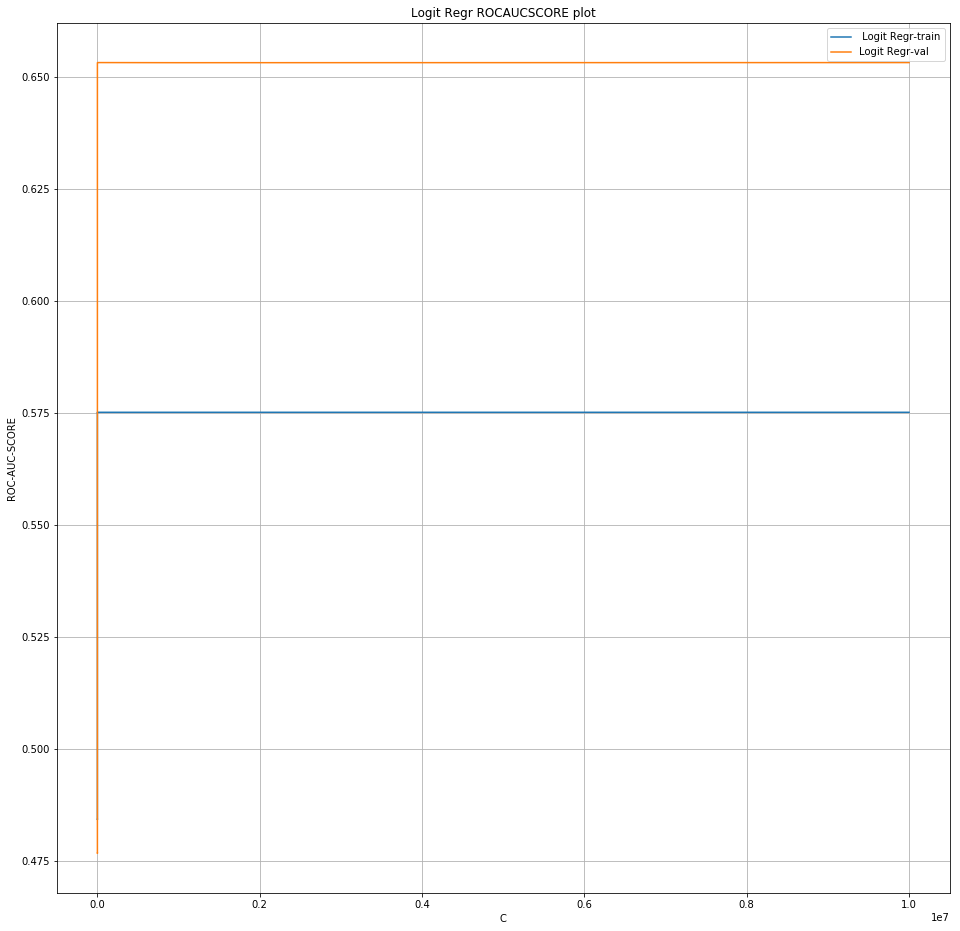

0.0001


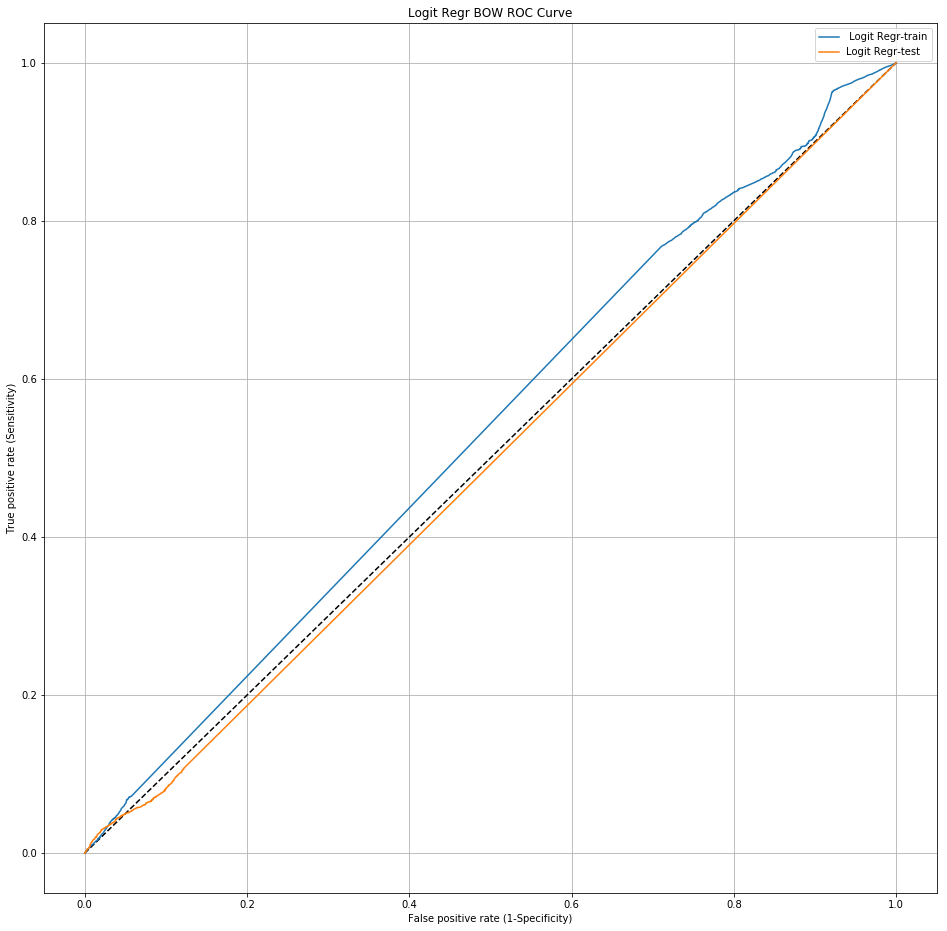

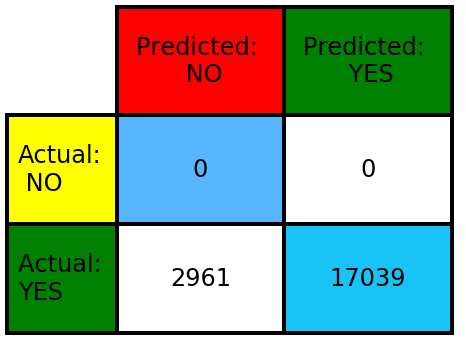

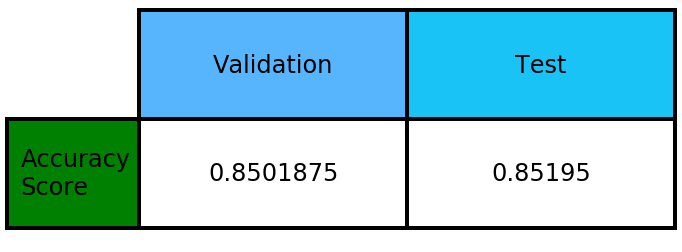

In [20]:

print(return_hyparmtune[0],return_hyparmtune[1],return_hyparmtune[2])

#hyper parameter results 0.5735932894235685 {'C': 0.0001}

#generate multiple rocauc scores by varying lambda
logregr_tfidfwtw2v.calcrocaucscore_logregrsn(10000000)

print(len(logregr_tfidfwtw2v.rocaucscoretrn))
print(len(logregr_tfidfwtw2v.rocaucscoreval))
print(len(logregr_tfidfwtw2v.logrgr_lambda))

#plot graph of the rocauc scores
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr ROCAUCSCORE plot'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-val'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='C'
displaygraph.label_y='ROC-AUC-SCORE'
displaygraph.Xdata = logregr_tfidfwtw2v.logrgr_lambda
displaygraph.ydatatrn = logregr_tfidfwtw2v.rocaucscoretrn[:19]
displaygraph.ydataval = logregr_tfidfwtw2v.rocaucscoreval
displaygraph.rocacuscoregraph()

#using hyperparameter value process logistic regression using test data
logregr_tfidfwtw2v.actualClasifier_logregrsn(0.0001)


#plot the rocauc scores
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.graph_title='Logit Regr BOW ROC Curve'
displaygraph.legnd_1 = ' Logit Regr-train'
displaygraph.legnd_2 = 'Logit Regr-test'
displaygraph.graph_parameters['show_legnd']= True
displaygraph.label_x='False positive rate (1-Specificity)'
displaygraph.label_y='True positive rate (Sensitivity)'
displaygraph.constructgraph(logregr_tfidfwtw2v.roc_curve_test['fpr_trn'],logregr_tfidfwtw2v.roc_curve_test['tpr_trn'],\
                            logregr_tfidfwtw2v.roc_curve_test['fpr'],logregr_tfidfwtw2v.roc_curve_test['tpr'])

#display the confusion matrix
data = [[logregr_tfidfwtw2v.confsnmtxytstpred['tn'] ,logregr_tfidfwtw2v.confsnmtxytstpred['fn']],[logregr_tfidfwtw2v.confsnmtxytstpred['fp'],logregr_tfidfwtw2v.confsnmtxytstpred['tp']]]
displaygraph.draw_table(data)

#display accuracy score
data1= [[logregr_tfidfwtw2v.accuracy_score_val,logregr_tfidfwtw2v.accuracy_score_test]]
displaygraph.draw_accscore(data1)


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [21]:
#set lambda and penalty
logregr_tfidfwtw2v.set_penaltyparm('l1')
logregr_tfidfwtw2v.set_lambdaparm(0.001)
#fit test data
logregr_tfidfwtw2v.logRegr_fitdata(logregr_tfidfwtw2v.xtest,logregr_tfidfwtw2v.ytest)
print(log_regr_tfidfwtw2v)
#get coefficients
w = log_regr_tfidfwtw2v.coef_
print(np.count_nonzero(w))

#set lambda and penalty
logregr_tfidfwtw2v.set_penaltyparm('l1')
logregr_tfidfwtw2v.set_lambdaparm(0.1)
#fit test data
logregr_tfidfwtw2v.logRegr_fitdata(logregr_tfidfwtw2v.xtest,logregr_tfidfwtw2v.ytest)
print(log_regr_tfidfwtw2v)
#get coefficients
w = log_regr_tfidfwtw2v.coef_
print(np.count_nonzero(w))

#set lambda and penalty
logregr_tfidfwtw2v.set_penaltyparm('l1')
logregr_tfidfwtw2v.set_lambdaparm(1)
#fit test data
logregr_tfidfwtw2v.logRegr_fitdata(logregr_tfidfwtw2v.xtest,logregr_tfidfwtw2v.ytest)
print(log_regr_tfidfwtw2v)
#get coefficients
w = log_regr_tfidfwtw2v.coef_
print(np.count_nonzero(w))

#set lambda and penalty
logregr_tfidfwtw2v.set_penaltyparm('l1')
logregr_tfidfwtw2v.set_lambdaparm(10)
#fit test data
logregr_tfidfwtw2v.logRegr_fitdata(logregr_tfidfwtw2v.xtest,logregr_tfidfwtw2v.ytest)
print(log_regr_tfidfwtw2v)
#get coefficients
w = log_regr_tfidfwtw2v.coef_
print(np.count_nonzero(w))

0.001
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0
0.1
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
4
1
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
8
10
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42

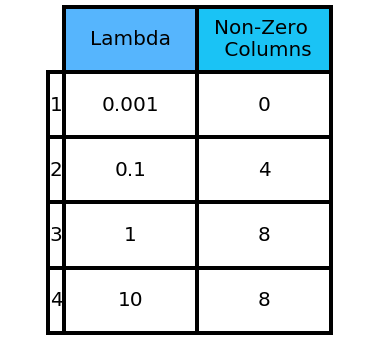

In [22]:
data2= [[0.001,0],[0.1,4],[1,8],[10,8]]
displaygraph = drawgraphs()
displaygraph.setdefaultparm()
displaygraph.draw_sparsity(data2)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [50]:
logregr_tfidfwtw2v.set_penaltyparm('l2')
logregr_tfidfwtw2v.set_lambdaparm(0.0001)
logregr_tfidfwtw2v.logRegr_fitdata(logregr_tfidfwtw2v.xtest,logregr_tfidfwtw2v.ytest)
print(log_regr_tfidfwtw2v)
#print(log_regr_tfidfwtw2v.coef_)
w1 = log_regr_tfidfwtw2v.coef_
print(np.count_nonzero(w1))

0.0001
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
50


# [6] Conclusions

In [0]:
# Please compare all your models using Prettytable library

In [27]:
from prettytable import from_html_one
L1  =  '<html>'
L2  =  '<head>'

L3  =  '<STYLE TYPE="text/css">'
L4  =  '<!--'
L5  =  'td {font-family: Arial; font-size: 10pt; background-color: #000000; color: white;}'
L6  =  'THEAD {font-family: Arial; font-size: 14pt; background-color: #000000; color: white;}'
L7  =  '--->'
L8  =  '</STYLE>'

L9  =  '</head>'
L10  =  '<body>'

L11  =  '<table border=1 solid> '
L12  =  '<tr>'
L13  =  '<th>Vectorizer </th>'
L14  =  '<th>Model </th>'
L15  =  '<th>Hyper Parameter</th>'
L16  =  '<th>AUC</th>'
L17  =  '</tr>'
L18  =  '<tr bgcolor="black"><td> BOW </td><td> Logistic Regression </td><td> 1 </td><td> 0.9233</td></tr>'
L19  =  '<tr><td> TFIDF </td><td> Logistic Regression </td><td> 10 </td><td> 0.9938</td></tr>'
L20  =  '<tr><td> W2V </td><td> Logistic Regression </td><td> 1 </td><td> 0.8773</td></tr>'
L21  =  '<tr><td> TFIDFW2V </td><td> Logistic Regression </td><td> 0.0001 </td><td> 0.8520</td></tr>'

L22  =  '</table>'

L23  =  '</body>'
L24  =  '</html>'

html_string = L1+L2+L3+L4+L5+L6+L7+L8+L9+L10+L11+L12+L13+L14+L15+L16+L17+L18+L19+L20+L21+L22+L23+L24

#html_string = L1+L2+L3+L4+L5+L6+L7+L8+L9+L10+L11+L12+L13+L14+L15+L16+L17+L18+L22+L23+L24
tbl = from_html_one(html_string)

print(tbl)

+------------+---------------------+-----------------+--------+
| Vectorizer |        Model        | Hyper Parameter |  AUC   |
+------------+---------------------+-----------------+--------+
|    BOW     | Logistic Regression |        1        | 0.9233 |
|   TFIDF    | Logistic Regression |        10       | 0.9938 |
|    W2V     | Logistic Regression |        1        | 0.8773 |
|  TFIDFW2V  | Logistic Regression |      0.0001     | 0.8520 |
+------------+---------------------+-----------------+--------+


In [26]:
from prettytable import from_html_one
L1  =  '<html>'
L2  =  '<head>'

L3  =  '<STYLE TYPE="text/css">'
L4  =  '<!--'
L5  =  'td {font-family: Arial; font-size: 10pt; background-color: #000000; color: white;}'
L6  =  'THEAD {font-family: Arial; font-size: 14pt; background-color: #000000; color: white;}'
L7  =  '--->'
L8  =  '</STYLE>'

L9  =  '</head>'
L10  =  '<body>'

L11  =  '<table border=1 solid> '
L12  =  '<tr>'
L13  =  '<th>Lambda </th>'
L14  =  '<th>Bag Of words </th>'
L15  =  '<th>Tf-IDF</th>'
L16  =  '<th>Avgw2v</th>'
L17  =  '<th>TfIdf-wt-w2v</th></tr>'
L18  =  '<tr bgcolor="black"><td> 0.001 </td><td> 0 </td><td> 0 </td><td> 2</td><td> 0</td></tr>'
L19  =  '<tr><td> 0.1 </td><td> 369 </td><td> 28 </td><td> 33</td><td> 4</td></tr>'
L20  =  '<tr><td> 1 </td><td> 882 </td><td> 474 </td><td> 50</td><td> 8</td></tr>'
L21  =  '<tr><td> 10 </td><td> 987 </td><td> 3182 </td><td> 49</td><td> 8</td></tr>'

L22  =  '</table>'

L23  =  '</body>'
L24  =  '</html>'

html_string = L1+L2+L3+L4+L5+L6+L7+L8+L9+L10+L11+L12+L13+L14+L15+L16+L17+L18+L19+L20+L21+L22+L23+L24

#html_string = L1+L2+L3+L4+L5+L6+L7+L8+L9+L10+L11+L12+L13+L14+L15+L16+L17+L18+L22+L23+L24
tbl = from_html_one(html_string)

print(tbl)

+--------+--------------+--------+--------+--------------+
| Lambda | Bag Of words | Tf-IDF | Avgw2v | TfIdf-wt-w2v |
+--------+--------------+--------+--------+--------------+
| 0.001  |      0       |   0    |   2    |      0       |
|  0.1   |     369      |   28   |   33   |      4       |
|   1    |     882      |  474   |   50   |      8       |
|   10   |     987      |  3182  |   49   |      8       |
+--------+--------------+--------+--------+--------------+
